In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, LeakyReLU,Conv1D, Conv1DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanAbsoluteError
from scipy.signal import resample
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.legacy import Adam



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#downsampling shape
data_dir = '/content/drive/MyDrive/bidmc_csv-20230924T070751Z-001/bidmc_csv'
#data_dir = '/content/drive/MyDrive/bidmc_csv'

patient_id = 1
signal_data = pd.read_csv(os.path.join(data_dir, f'/content/drive/MyDrive/bidmc_csv-20230924T070751Z-001/bidmc_csv/bidmc_{patient_id:02d}_Signals.csv'))
#signal_data = pd.read_csv(os.path.join(data_dir, f'/content/drive/MyDrive/bidmc_csv/bidmc_{patient_id:02d}_Signals.csv'))

ppg_signals = signal_data[' PLETH'].values  # Assuming 'PLETH' column contains PPG signals
respiratory_signals = signal_data[' RESP'].values  # Assuming 'RESP' column contains respiratory signals

    # Down-sample to 30 Hz
desired_sample_rate = 30
original_sample_rate = 125


resampling_factor = desired_sample_rate / original_sample_rate


ppg_signals = resample(ppg_signals, int(len(ppg_signals) * resampling_factor))
respiratory_signals = resample(respiratory_signals, int(len(respiratory_signals) * resampling_factor))


ppg_signals = (ppg_signals - np.min(ppg_signals)) / (np.max(ppg_signals) - np.min(ppg_signals))
respiratory_signals = (respiratory_signals - np.min(respiratory_signals)) / (np.max(respiratory_signals) - np.min(respiratory_signals))
print(np.shape(ppg_signals))

(14400,)


In [ ]:

window_size = 30 * desired_sample_rate


frames = len(ppg_signals) // window_size


ppg_signals_reshaped = ppg_signals[:frames * window_size].reshape((frames, window_size, 1))


respiratory_signals_reshaped = respiratory_signals[:frames * window_size].reshape((frames, window_size, 1))


ppg_signals_reshaped = (ppg_signals_reshaped - np.min(ppg_signals_reshaped)) / (np.max(ppg_signals_reshaped) - np.min(ppg_signals_reshaped))
respiratory_signals_reshaped = (respiratory_signals_reshaped - np.min(respiratory_signals_reshaped)) / (np.max(respiratory_signals_reshaped) - np.min(respiratory_signals_reshaped))

print(np.shape(ppg_signals_reshaped))


(16, 900, 1)


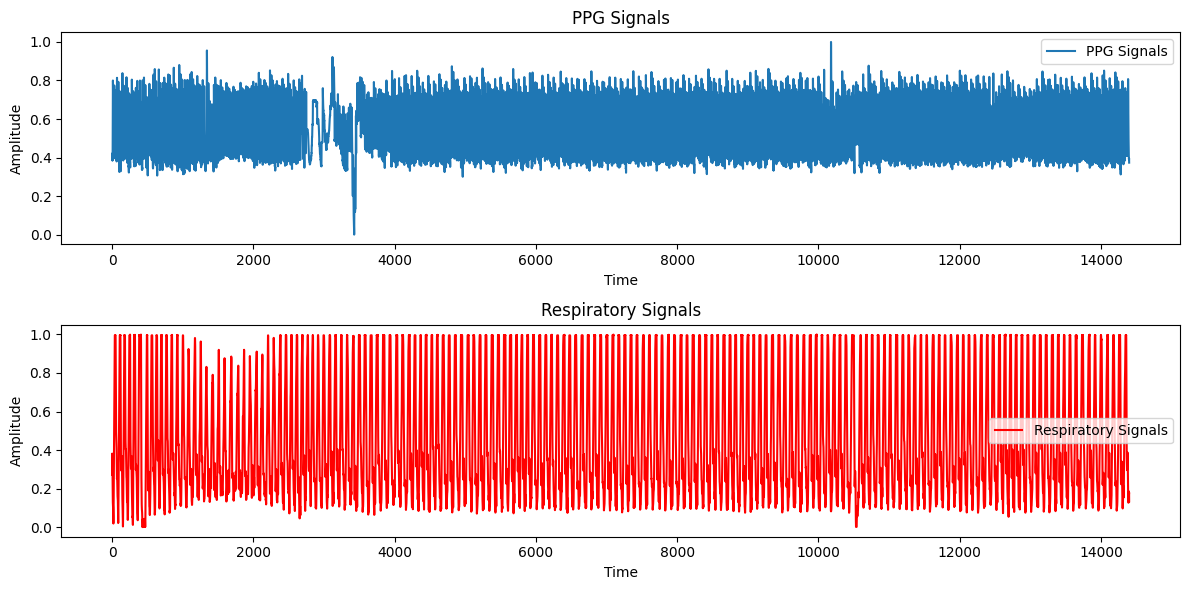

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(ppg_signals, label='PPG Signals')
plt.title('PPG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(respiratory_signals, label='Respiratory Signals', color='r')
plt.title('Respiratory Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def build_generator(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    outputs = Conv1D(output_shape[-1], kernel_size=3, padding='same', activation='sigmoid')(x)
    return Model(inputs, outputs)

def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    outputs = Conv1D(1, kernel_size=3, padding='same', activation='sigmoid')(x)
    return Model(inputs, outputs)



# Load and preprocess the dataset for a single patient
def load_and_preprocess_patient_data(patient_id, data_dir):
    breaths_data = pd.read_csv(os.path.join(data_dir, f'/content/drive/MyDrive/bidmc_csv-20230924T070751Z-001/bidmc_csv/bidmc_{patient_id:02d}_Breaths.csv'))
    numerics_data = pd.read_csv(os.path.join(data_dir, f'/content/drive/MyDrive/bidmc_csv-20230924T070751Z-001/bidmc_csv/bidmc_{patient_id:02d}_Numerics.csv'))
    signal_data = pd.read_csv(os.path.join(data_dir, f'/content/drive/MyDrive/bidmc_csv-20230924T070751Z-001/bidmc_csv/bidmc_{patient_id:02d}_Signals.csv'))
    #breaths_data = pd.read_csv(os.path.join(data_dir, f'/content/drive/MyDrive/bidmc_csv/bidmc_{patient_id:02d}_Breaths.csv'))
    #numerics_data = pd.read_csv(os.path.join(data_dir, f'/content/drive/MyDrive/bidmc_csv/bidmc_{patient_id:02d}_Numerics.csv'))
    #signal_data = pd.read_csv(os.path.join(data_dir, f'/content/drive/MyDrive/bidmc_csv/bidmc_{patient_id:02d}_Signals.csv'))


    ppg_signals = signal_data[' PLETH'].values
    respiratory_signals = signal_data[' RESP'].values

    desired_sample_rate = 30
    original_sample_rate = 125

    resampling_factor = desired_sample_rate / original_sample_rate

    ppg_signals = resample(ppg_signals, int(len(ppg_signals) * resampling_factor))
    respiratory_signals = resample(respiratory_signals, int(len(respiratory_signals) * resampling_factor))

    window_size = 30 * desired_sample_rate

    frames = len(ppg_signals) // window_size

    ppg_signals_reshaped = ppg_signals[:frames * window_size].reshape((frames, window_size, 1))

    respiratory_signals_reshaped = respiratory_signals[:frames * window_size].reshape((frames, window_size, 1))

    ppg_signals_reshaped = (ppg_signals_reshaped - np.min(ppg_signals_reshaped)) / (np.max(ppg_signals_reshaped) - np.min(ppg_signals_reshaped))
    respiratory_signals_reshaped = (respiratory_signals_reshaped - np.min(respiratory_signals_reshaped)) / (np.max(respiratory_signals_reshaped) - np.min(respiratory_signals_reshaped))

    processed_data = {'PPG': ppg_signals_reshaped, 'Respiratory': respiratory_signals_reshaped}

    return processed_data




In [ ]:
from sklearn.model_selection import GroupKFold

if __name__ == "__main__":
    data_dir = '/content/drive/MyDrive/bidmc_csv-20230924T070751Z-001/bidmc_csv'
    #data_dir = '/content/drive/MyDrive/bidmc_csv'
    num_patients = 53

    all_processed_ppg = []
    all_processed_respiratory = []
    patient_ids = []

    for patient_id in range(1, num_patients + 1):
        processed_data = load_and_preprocess_patient_data(patient_id, data_dir)

        data_X = processed_data['PPG']
        data_Y = processed_data['Respiratory']

        num_samples = len(data_X)
        data_X = data_X.reshape(num_samples, -1, 1)
        data_Y = data_Y.reshape(num_samples, -1, 1)

        all_processed_ppg.append(data_X)
        all_processed_respiratory.append(data_Y)
        patient_ids.extend([patient_id] * len(data_X))

    concatenated_ppg = np.concatenate(all_processed_ppg, axis=0)
    concatenated_respiratory = np.concatenate(all_processed_respiratory, axis=0)


    num_folds = 5
    gkf = GroupKFold(n_splits=num_folds)

    fold = 1
    for train_index, test_index in gkf.split(concatenated_ppg, groups=patient_ids):

        train_X, test_X = concatenated_ppg[train_index], concatenated_ppg[test_index]
        train_Y, test_Y = concatenated_respiratory[train_index], concatenated_respiratory[test_index]

        print(f"Fold {fold} - Train data shape: {train_X.shape}, Test data shape: {test_X.shape}")

        fold += 1


Fold 1 - Train data shape: (672, 900, 1), Test data shape: (176, 900, 1)
Fold 2 - Train data shape: (672, 900, 1), Test data shape: (176, 900, 1)
Fold 3 - Train data shape: (672, 900, 1), Test data shape: (176, 900, 1)
Fold 4 - Train data shape: (688, 900, 1), Test data shape: (160, 900, 1)
Fold 5 - Train data shape: (688, 900, 1), Test data shape: (160, 900, 1)


In [ ]:
from sklearn.model_selection import GroupKFold
import numpy as np

def train_cycle_gan(data_X, data_Y, epochs, batch_size):
    input_shape = data_X.shape[1:]
    generator_XY = build_generator(input_shape, data_Y.shape[1:])
    generator_YX = build_generator(input_shape, data_X.shape[1:])

    discriminator_X = build_discriminator(input_shape)
    discriminator_Y = build_discriminator(input_shape)

    generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

    generator_XY.compile(optimizer=generator_optimizer, loss='mean_absolute_error')
    generator_YX.compile(optimizer=generator_optimizer, loss='mean_absolute_error')
    discriminator_X.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
    discriminator_Y.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

    dataset = tf.data.Dataset.from_tensor_slices((data_X, data_Y)).batch(batch_size)
    # real_labels = tf.ones((batch_X.shape[0], 1))
    # fake_labels = tf.zeros((batch_X.shape[0], 1))
    for epoch in range(epochs):
        with tqdm(total=len(data_X)//batch_size, desc=f'Epoch {epoch+1}') as pbar:
            for batch_X, batch_Y in dataset:
                fake_Y = generator_XY.predict(batch_X)
                fake_X = generator_YX.predict(batch_Y)
                real_labels = tf.ones((batch_X.shape[0], 1))
                fake_labels = tf.zeros((batch_X.shape[0], 1))

                dX_loss_real = discriminator_X.train_on_batch(batch_X, real_labels)
                dY_loss_real = discriminator_Y.train_on_batch(batch_Y, real_labels)
                dX_loss_fake = discriminator_X.train_on_batch(fake_X, fake_labels)
                dY_loss_fake = discriminator_Y.train_on_batch(fake_Y, fake_labels)

                gXY_loss = generator_XY.train_on_batch(batch_X, batch_Y)
                gYX_loss = generator_YX.train_on_batch(batch_Y, batch_X)

                pbar.update(1)

    return generator_XY
        # Print loss for this epoch
                  #print(f'Epoch {epoch + 1}, dX_loss_real: {dX_loss_real}, dY_loss_real: {dY_loss_real}, '
              #f'dX_loss_fake: {dX_loss_fake}, dY_loss_fake: {dY_loss_fake}, '
             # f'gXY_loss: {gXY_loss}, gYX_loss: {gYX_loss}')

# Define a function to evaluate the CycleGAN model
#def evaluate_cycle_gan(test_X, test_Y):
    # Evaluation code for CycleGAN here
    # Use test_X and test_Y for evaluation

In [ ]:
def evaluate_cycle_gan(generator_XY, test_X, test_Y):

    synthetic_respiratory_signals = generator_XY.predict(test_X)

    absolute_errors = np.abs(synthetic_respiratory_signals - test_Y)

    mae = np.mean(absolute_errors)

    return mae

In [ ]:
if __name__ == "__main__":
    data_dir = '/content/drive/MyDrive/bidmc_csv'
    num_patients = 53

    all_processed_ppg = []
    all_processed_respiratory = []
    patient_ids = []
    mae_values = []

    for patient_id in range(1, num_patients + 1):
        processed_data = load_and_preprocess_patient_data(patient_id, data_dir)

        data_X = processed_data['PPG']
        data_Y = processed_data['Respiratory']

        num_samples = len(data_X)
        data_X = data_X.reshape(num_samples, -1, 1)
        data_Y = data_Y.reshape(num_samples, -1, 1)


        all_processed_ppg.append(data_X)
        all_processed_respiratory.append(data_Y)
        patient_ids.extend([patient_id] * len(data_X))

    concatenated_ppg = np.concatenate(all_processed_ppg, axis=0)
    concatenated_respiratory = np.concatenate(all_processed_respiratory, axis=0)

    num_folds = 5
    gkf = GroupKFold(n_splits=num_folds)

    fold = 1
    for train_index, test_index in gkf.split(concatenated_ppg, groups=patient_ids):
        train_X, test_X = concatenated_ppg[train_index], concatenated_ppg[test_index]
        train_Y, test_Y = concatenated_respiratory[train_index], concatenated_respiratory[test_index]


        generator_XY=train_cycle_gan(train_X, train_Y, epochs=20, batch_size=32)

        mae = evaluate_cycle_gan(generator_XY, test_X, test_Y)
        mae_values.append(mae)

        print(f"Fold {fold} - Training and evaluation completed. MAE: {mae}")

        fold += 1


    average_mae = np.mean(mae_values)
    print(f"Average MAE across {num_folds} folds: {average_mae}")






Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 166ms/step


Epoch 1:   5%|▍         | 1/21 [00:18<06:09, 18.47s/it]

1/1 [==============================] - 0s 15ms/step


Epoch 1:  10%|▉         | 2/21 [00:19<02:31,  7.99s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  14%|█▍        | 3/21 [00:19<01:23,  4.64s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  19%|█▉        | 4/21 [00:20<00:52,  3.06s/it]

1/1 [==============================] - 0s 15ms/step


Epoch 1:  24%|██▍       | 5/21 [00:21<00:35,  2.19s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 1:  29%|██▊       | 6/21 [00:21<00:26,  1.75s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1:  33%|███▎      | 7/21 [00:22<00:20,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1:  38%|███▊      | 8/21 [00:23<00:16,  1.28s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 1:  43%|████▎     | 9/21 [00:24<00:13,  1.14s/it]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  48%|████▊     | 10/21 [00:25<00:10,  1.01it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  52%|█████▏    | 11/21 [00:25<00:09,  1.11it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  57%|█████▋    | 12/21 [00:26<00:07,  1.21it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  62%|██████▏   | 13/21 [00:27<00:06,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  67%|██████▋   | 14/21 [00:27<00:05,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  71%|███████▏  | 15/21 [00:28<00:04,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  76%|███████▌  | 16/21 [00:29<00:03,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  81%|████████  | 17/21 [00:29<00:02,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  86%|████████▌ | 18/21 [00:30<00:02,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  90%|█████████ | 19/21 [00:31<00:01,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  95%|█████████▌| 20/21 [00:32<00:00,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:   5%|▍         | 1/21 [00:00<00:12,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  10%|▉         | 2/21 [00:01<00:12,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 2:  14%|█▍        | 3/21 [00:02<00:14,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2:  19%|█▉        | 4/21 [00:03<00:14,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2:  24%|██▍       | 5/21 [00:04<00:14,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2:  29%|██▊       | 6/21 [00:05<00:12,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  33%|███▎      | 7/21 [00:05<00:11,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  43%|████▎     | 9/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  48%|████▊     | 10/21 [00:07<00:08,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2:  52%|█████▏    | 11/21 [00:08<00:07,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  57%|█████▋    | 12/21 [00:09<00:06,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  62%|██████▏   | 13/21 [00:09<00:05,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 2:  67%|██████▋   | 14/21 [00:10<00:04,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  71%|███████▏  | 15/21 [00:11<00:04,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  76%|███████▌  | 16/21 [00:11<00:03,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  81%|████████  | 17/21 [00:12<00:02,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  86%|████████▌ | 18/21 [00:13<00:02,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2:  90%|█████████ | 19/21 [00:13<00:01,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  95%|█████████▌| 20/21 [00:14<00:00,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3:   5%|▍         | 1/21 [00:01<00:21,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 3:  10%|▉         | 2/21 [00:01<00:18,  1.05it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  14%|█▍        | 3/21 [00:02<00:15,  1.19it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 3:  19%|█▉        | 4/21 [00:03<00:13,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  24%|██▍       | 5/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 3:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  33%|███▎      | 7/21 [00:05<00:10,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3:  38%|███▊      | 8/21 [00:06<00:09,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 3:  43%|████▎     | 9/21 [00:06<00:08,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  48%|████▊     | 10/21 [00:07<00:07,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 3:  52%|█████▏    | 11/21 [00:08<00:06,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  57%|█████▋    | 12/21 [00:08<00:06,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  62%|██████▏   | 13/21 [00:09<00:05,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  67%|██████▋   | 14/21 [00:10<00:04,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 3:  71%|███████▏  | 15/21 [00:10<00:04,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  76%|███████▌  | 16/21 [00:11<00:03,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3:  81%|████████  | 17/21 [00:12<00:03,  1.27it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 3:  86%|████████▌ | 18/21 [00:13<00:02,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 3:  90%|█████████ | 19/21 [00:14<00:01,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3:  95%|█████████▌| 20/21 [00:15<00:00,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:   5%|▍         | 1/21 [00:00<00:13,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  10%|▉         | 2/21 [00:01<00:13,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  14%|█▍        | 3/21 [00:02<00:12,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  19%|█▉        | 4/21 [00:02<00:11,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  24%|██▍       | 5/21 [00:03<00:11,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  29%|██▊       | 6/21 [00:04<00:10,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  33%|███▎      | 7/21 [00:04<00:09,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  38%|███▊      | 8/21 [00:05<00:08,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  43%|████▎     | 9/21 [00:06<00:08,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  48%|████▊     | 10/21 [00:06<00:07,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  52%|█████▏    | 11/21 [00:07<00:06,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  57%|█████▋    | 12/21 [00:08<00:06,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  62%|██████▏   | 13/21 [00:09<00:05,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 4:  67%|██████▋   | 14/21 [00:10<00:05,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 4:  71%|███████▏  | 15/21 [00:11<00:05,  1.12it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4:  76%|███████▌  | 16/21 [00:12<00:04,  1.11it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  81%|████████  | 17/21 [00:12<00:03,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  86%|████████▌ | 18/21 [00:13<00:02,  1.25it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 4:  90%|█████████ | 19/21 [00:14<00:01,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  95%|█████████▌| 20/21 [00:14<00:00,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:   5%|▍         | 1/21 [00:00<00:15,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5:  10%|▉         | 2/21 [00:01<00:14,  1.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 5:  14%|█▍        | 3/21 [00:02<00:15,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5:  19%|█▉        | 4/21 [00:03<00:16,  1.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5:  24%|██▍       | 5/21 [00:04<00:15,  1.05it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 5:  29%|██▊       | 6/21 [00:05<00:13,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  33%|███▎      | 7/21 [00:05<00:11,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  38%|███▊      | 8/21 [00:06<00:10,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  43%|████▎     | 9/21 [00:07<00:09,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  48%|████▊     | 10/21 [00:08<00:08,  1.34it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 5:  52%|█████▏    | 11/21 [00:08<00:07,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  57%|█████▋    | 12/21 [00:09<00:06,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  62%|██████▏   | 13/21 [00:10<00:05,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  67%|██████▋   | 14/21 [00:11<00:05,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  71%|███████▏  | 15/21 [00:11<00:04,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  76%|███████▌  | 16/21 [00:12<00:03,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5:  81%|████████  | 17/21 [00:13<00:02,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  86%|████████▌ | 18/21 [00:13<00:02,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 5:  90%|█████████ | 19/21 [00:14<00:01,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  95%|█████████▌| 20/21 [00:15<00:00,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:   5%|▍         | 1/21 [00:00<00:15,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  10%|▉         | 2/21 [00:01<00:13,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  14%|█▍        | 3/21 [00:02<00:12,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  19%|█▉        | 4/21 [00:02<00:12,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  24%|██▍       | 5/21 [00:03<00:11,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  29%|██▊       | 6/21 [00:04<00:10,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  33%|███▎      | 7/21 [00:04<00:09,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  38%|███▊      | 8/21 [00:05<00:09,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  43%|████▎     | 9/21 [00:06<00:08,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6:  48%|████▊     | 10/21 [00:07<00:07,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 6:  52%|█████▏    | 11/21 [00:07<00:07,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 6:  57%|█████▋    | 12/21 [00:09<00:07,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 6:  62%|██████▏   | 13/21 [00:09<00:07,  1.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  67%|██████▋   | 14/21 [00:10<00:05,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6:  71%|███████▏  | 15/21 [00:11<00:04,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  76%|███████▌  | 16/21 [00:12<00:03,  1.32it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 6:  81%|████████  | 17/21 [00:12<00:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  86%|████████▌ | 18/21 [00:13<00:02,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  90%|█████████ | 19/21 [00:14<00:01,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 6:  95%|█████████▌| 20/21 [00:14<00:00,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7:   5%|▍         | 1/21 [00:00<00:18,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7:  10%|▉         | 2/21 [00:01<00:17,  1.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7:  14%|█▍        | 3/21 [00:02<00:15,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7:  19%|█▉        | 4/21 [00:03<00:13,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  24%|██▍       | 5/21 [00:04<00:12,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  33%|███▎      | 7/21 [00:05<00:10,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  38%|███▊      | 8/21 [00:06<00:09,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  43%|████▎     | 9/21 [00:06<00:08,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  48%|████▊     | 10/21 [00:07<00:07,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  52%|█████▏    | 11/21 [00:08<00:06,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  57%|█████▋    | 12/21 [00:08<00:06,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  62%|██████▏   | 13/21 [00:09<00:05,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  67%|██████▋   | 14/21 [00:10<00:04,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  71%|███████▏  | 15/21 [00:10<00:04,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  76%|███████▌  | 16/21 [00:11<00:03,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  81%|████████  | 17/21 [00:12<00:03,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7:  86%|████████▌ | 18/21 [00:13<00:02,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7:  90%|█████████ | 19/21 [00:14<00:01,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 7:  95%|█████████▌| 20/21 [00:15<00:00,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:   5%|▍         | 1/21 [00:00<00:14,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  10%|▉         | 2/21 [00:01<00:13,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  14%|█▍        | 3/21 [00:02<00:12,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  19%|█▉        | 4/21 [00:02<00:11,  1.43it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 8:  24%|██▍       | 5/21 [00:03<00:11,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  29%|██▊       | 6/21 [00:04<00:10,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  33%|███▎      | 7/21 [00:04<00:09,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8:  38%|███▊      | 8/21 [00:05<00:09,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  43%|████▎     | 9/21 [00:06<00:08,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  48%|████▊     | 10/21 [00:07<00:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  52%|█████▏    | 11/21 [00:07<00:07,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  57%|█████▋    | 12/21 [00:08<00:06,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 8:  62%|██████▏   | 13/21 [00:09<00:05,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8:  67%|██████▋   | 14/21 [00:10<00:05,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 8:  71%|███████▏  | 15/21 [00:11<00:04,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8:  76%|███████▌  | 16/21 [00:11<00:04,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8:  81%|████████  | 17/21 [00:12<00:03,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8:  86%|████████▌ | 18/21 [00:13<00:02,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  90%|█████████ | 19/21 [00:14<00:01,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  95%|█████████▌| 20/21 [00:14<00:00,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:   5%|▍         | 1/21 [00:00<00:13,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  10%|▉         | 2/21 [00:01<00:13,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  14%|█▍        | 3/21 [00:02<00:12,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9:  19%|█▉        | 4/21 [00:02<00:11,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  24%|██▍       | 5/21 [00:03<00:11,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9:  29%|██▊       | 6/21 [00:04<00:11,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9:  33%|███▎      | 7/21 [00:05<00:11,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9:  38%|███▊      | 8/21 [00:06<00:11,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9:  43%|████▎     | 9/21 [00:07<00:10,  1.12it/s]

1/1 [==============================] - 0s 51ms/step


Epoch 9:  48%|████▊     | 10/21 [00:08<00:10,  1.04it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9:  52%|█████▏    | 11/21 [00:09<00:09,  1.02it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9:  57%|█████▋    | 12/21 [00:10<00:08,  1.00it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  62%|██████▏   | 13/21 [00:11<00:07,  1.11it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  67%|██████▋   | 14/21 [00:11<00:05,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  71%|███████▏  | 15/21 [00:12<00:04,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9:  76%|███████▌  | 16/21 [00:13<00:03,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  81%|████████  | 17/21 [00:13<00:03,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  86%|████████▌ | 18/21 [00:14<00:02,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  90%|█████████ | 19/21 [00:15<00:01,  1.37it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 9:  95%|█████████▌| 20/21 [00:16<00:00,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10:   5%|▍         | 1/21 [00:00<00:13,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  10%|▉         | 2/21 [00:01<00:13,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  14%|█▍        | 3/21 [00:02<00:12,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  19%|█▉        | 4/21 [00:02<00:11,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  24%|██▍       | 5/21 [00:03<00:11,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10:  29%|██▊       | 6/21 [00:04<00:12,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 10:  33%|███▎      | 7/21 [00:05<00:12,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 10:  38%|███▊      | 8/21 [00:06<00:12,  1.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  43%|████▎     | 9/21 [00:07<00:10,  1.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  48%|████▊     | 10/21 [00:08<00:09,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  52%|█████▏    | 11/21 [00:08<00:07,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  57%|█████▋    | 12/21 [00:09<00:06,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10:  62%|██████▏   | 13/21 [00:10<00:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  67%|██████▋   | 14/21 [00:10<00:05,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  71%|███████▏  | 15/21 [00:11<00:04,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  76%|███████▌  | 16/21 [00:12<00:03,  1.43it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 10:  81%|████████  | 17/21 [00:12<00:02,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  86%|████████▌ | 18/21 [00:13<00:02,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  90%|█████████ | 19/21 [00:14<00:01,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  95%|█████████▌| 20/21 [00:14<00:00,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:   5%|▍         | 1/21 [00:00<00:13,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  10%|▉         | 2/21 [00:01<00:15,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11:  14%|█▍        | 3/21 [00:02<00:16,  1.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11:  19%|█▉        | 4/21 [00:03<00:16,  1.04it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11:  24%|██▍       | 5/21 [00:04<00:14,  1.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  29%|██▊       | 6/21 [00:05<00:12,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  33%|███▎      | 7/21 [00:05<00:11,  1.25it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 11:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  43%|████▎     | 9/21 [00:07<00:08,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11:  48%|████▊     | 10/21 [00:07<00:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  52%|█████▏    | 11/21 [00:08<00:07,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 11:  57%|█████▋    | 12/21 [00:09<00:06,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  62%|██████▏   | 13/21 [00:10<00:05,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  67%|██████▋   | 14/21 [00:10<00:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  71%|███████▏  | 15/21 [00:11<00:04,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  76%|███████▌  | 16/21 [00:12<00:03,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  81%|████████  | 17/21 [00:12<00:02,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11:  86%|████████▌ | 18/21 [00:13<00:02,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  90%|█████████ | 19/21 [00:14<00:01,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 11:  95%|█████████▌| 20/21 [00:15<00:00,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:   5%|▍         | 1/21 [00:00<00:15,  1.28it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 12:  10%|▉         | 2/21 [00:01<00:14,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  14%|█▍        | 3/21 [00:02<00:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  19%|█▉        | 4/21 [00:02<00:12,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  24%|██▍       | 5/21 [00:03<00:11,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  29%|██▊       | 6/21 [00:04<00:10,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12:  33%|███▎      | 7/21 [00:05<00:10,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  38%|███▊      | 8/21 [00:05<00:09,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  43%|████▎     | 9/21 [00:06<00:08,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12:  48%|████▊     | 10/21 [00:07<00:08,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12:  52%|█████▏    | 11/21 [00:08<00:08,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 12:  57%|█████▋    | 12/21 [00:09<00:08,  1.11it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  62%|██████▏   | 13/21 [00:10<00:06,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  67%|██████▋   | 14/21 [00:10<00:05,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  71%|███████▏  | 15/21 [00:11<00:04,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 12:  81%|████████  | 17/21 [00:12<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  86%|████████▌ | 18/21 [00:13<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  90%|█████████ | 19/21 [00:14<00:01,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  95%|█████████▌| 20/21 [00:15<00:00,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13:   5%|▍         | 1/21 [00:00<00:14,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  10%|▉         | 2/21 [00:01<00:13,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  14%|█▍        | 3/21 [00:02<00:12,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  19%|█▉        | 4/21 [00:02<00:12,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  24%|██▍       | 5/21 [00:03<00:11,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13:  29%|██▊       | 6/21 [00:04<00:12,  1.18it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13:  33%|███▎      | 7/21 [00:05<00:12,  1.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13:  38%|███▊      | 8/21 [00:06<00:12,  1.08it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 13:  43%|████▎     | 9/21 [00:07<00:10,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  48%|████▊     | 10/21 [00:08<00:09,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  52%|█████▏    | 11/21 [00:08<00:07,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  57%|█████▋    | 12/21 [00:09<00:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  62%|██████▏   | 13/21 [00:10<00:05,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  67%|██████▋   | 14/21 [00:10<00:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  71%|███████▏  | 15/21 [00:11<00:04,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  76%|███████▌  | 16/21 [00:12<00:03,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  81%|████████  | 17/21 [00:13<00:02,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  86%|████████▌ | 18/21 [00:13<00:02,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13:  90%|█████████ | 19/21 [00:14<00:01,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  95%|█████████▌| 20/21 [00:15<00:00,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:   5%|▍         | 1/21 [00:00<00:14,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 14:  10%|▉         | 2/21 [00:01<00:16,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14:  14%|█▍        | 3/21 [00:02<00:16,  1.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14:  19%|█▉        | 4/21 [00:03<00:16,  1.03it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  24%|██▍       | 5/21 [00:04<00:14,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  29%|██▊       | 6/21 [00:05<00:12,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  33%|███▎      | 7/21 [00:05<00:10,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  43%|████▎     | 9/21 [00:07<00:08,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  48%|████▊     | 10/21 [00:07<00:07,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 14:  52%|█████▏    | 11/21 [00:08<00:07,  1.41it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 14:  57%|█████▋    | 12/21 [00:09<00:06,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  62%|██████▏   | 13/21 [00:10<00:05,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  67%|██████▋   | 14/21 [00:10<00:04,  1.41it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 14:  71%|███████▏  | 15/21 [00:11<00:04,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  76%|███████▌  | 16/21 [00:12<00:03,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  81%|████████  | 17/21 [00:12<00:02,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  86%|████████▌ | 18/21 [00:13<00:02,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14:  90%|█████████ | 19/21 [00:14<00:01,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14:  95%|█████████▌| 20/21 [00:15<00:00,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 15:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:   5%|▍         | 1/21 [00:00<00:14,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  10%|▉         | 2/21 [00:01<00:13,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  14%|█▍        | 3/21 [00:02<00:12,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  19%|█▉        | 4/21 [00:02<00:11,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15:  24%|██▍       | 5/21 [00:03<00:11,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  29%|██▊       | 6/21 [00:04<00:11,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  33%|███▎      | 7/21 [00:05<00:10,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  38%|███▊      | 8/21 [00:05<00:09,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  43%|████▎     | 9/21 [00:06<00:08,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  48%|████▊     | 10/21 [00:07<00:07,  1.41it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 15:  52%|█████▏    | 11/21 [00:07<00:06,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  57%|█████▋    | 12/21 [00:08<00:06,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  62%|██████▏   | 13/21 [00:09<00:05,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 15:  67%|██████▋   | 14/21 [00:09<00:05,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 15:  71%|███████▏  | 15/21 [00:11<00:04,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 15:  76%|███████▌  | 16/21 [00:11<00:04,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 15:  81%|████████  | 17/21 [00:12<00:03,  1.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  86%|████████▌ | 18/21 [00:13<00:02,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  90%|█████████ | 19/21 [00:14<00:01,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  95%|█████████▌| 20/21 [00:15<00:00,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 16:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:   5%|▍         | 1/21 [00:00<00:15,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  10%|▉         | 2/21 [00:01<00:13,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 16:  14%|█▍        | 3/21 [00:02<00:12,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16:  19%|█▉        | 4/21 [00:03<00:13,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16:  24%|██▍       | 5/21 [00:04<00:13,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16:  29%|██▊       | 6/21 [00:04<00:12,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16:  33%|███▎      | 7/21 [00:05<00:12,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  38%|███▊      | 8/21 [00:06<00:10,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  43%|████▎     | 9/21 [00:07<00:09,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  48%|████▊     | 10/21 [00:07<00:08,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  52%|█████▏    | 11/21 [00:08<00:07,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  57%|█████▋    | 12/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 16:  62%|██████▏   | 13/21 [00:10<00:06,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  67%|██████▋   | 14/21 [00:10<00:05,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16:  71%|███████▏  | 15/21 [00:11<00:04,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  76%|███████▌  | 16/21 [00:12<00:03,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  81%|████████  | 17/21 [00:13<00:02,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  86%|████████▌ | 18/21 [00:13<00:02,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 16:  90%|█████████ | 19/21 [00:14<00:01,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  95%|█████████▌| 20/21 [00:15<00:00,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:   5%|▍         | 1/21 [00:00<00:15,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  10%|▉         | 2/21 [00:01<00:13,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  14%|█▍        | 3/21 [00:02<00:12,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  19%|█▉        | 4/21 [00:02<00:12,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  24%|██▍       | 5/21 [00:03<00:11,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  29%|██▊       | 6/21 [00:04<00:10,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  33%|███▎      | 7/21 [00:05<00:10,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  38%|███▊      | 8/21 [00:05<00:09,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  43%|████▎     | 9/21 [00:06<00:08,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  48%|████▊     | 10/21 [00:07<00:07,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  52%|█████▏    | 11/21 [00:08<00:07,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 17:  57%|█████▋    | 12/21 [00:08<00:07,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17:  62%|██████▏   | 13/21 [00:10<00:07,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17:  67%|██████▋   | 14/21 [00:10<00:06,  1.13it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  71%|███████▏  | 15/21 [00:11<00:05,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  76%|███████▌  | 16/21 [00:12<00:04,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  81%|████████  | 17/21 [00:13<00:03,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  86%|████████▌ | 18/21 [00:13<00:02,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  90%|█████████ | 19/21 [00:14<00:01,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  95%|█████████▌| 20/21 [00:15<00:00,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:   5%|▍         | 1/21 [00:00<00:14,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18:  10%|▉         | 2/21 [00:01<00:14,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  14%|█▍        | 3/21 [00:02<00:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  19%|█▉        | 4/21 [00:02<00:12,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  24%|██▍       | 5/21 [00:03<00:11,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18:  29%|██▊       | 6/21 [00:04<00:11,  1.36it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 18:  33%|███▎      | 7/21 [00:05<00:11,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 18:  38%|███▊      | 8/21 [00:06<00:11,  1.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 18:  43%|████▎     | 9/21 [00:07<00:11,  1.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  48%|████▊     | 10/21 [00:08<00:09,  1.16it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18:  52%|█████▏    | 11/21 [00:08<00:08,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18:  57%|█████▋    | 12/21 [00:09<00:07,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18:  62%|██████▏   | 13/21 [00:10<00:06,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  67%|██████▋   | 14/21 [00:11<00:05,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  71%|███████▏  | 15/21 [00:11<00:04,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  76%|███████▌  | 16/21 [00:12<00:03,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  81%|████████  | 17/21 [00:13<00:02,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18:  86%|████████▌ | 18/21 [00:13<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  90%|█████████ | 19/21 [00:14<00:01,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  95%|█████████▌| 20/21 [00:15<00:00,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:   5%|▍         | 1/21 [00:00<00:15,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19:  10%|▉         | 2/21 [00:01<00:14,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  14%|█▍        | 3/21 [00:02<00:12,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  19%|█▉        | 4/21 [00:02<00:12,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  24%|██▍       | 5/21 [00:03<00:11,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  29%|██▊       | 6/21 [00:04<00:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  33%|███▎      | 7/21 [00:05<00:10,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  38%|███▊      | 8/21 [00:05<00:09,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  43%|████▎     | 9/21 [00:06<00:08,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  48%|████▊     | 10/21 [00:07<00:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  52%|█████▏    | 11/21 [00:08<00:07,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  57%|█████▋    | 12/21 [00:08<00:06,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  62%|██████▏   | 13/21 [00:09<00:06,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 19:  67%|██████▋   | 14/21 [00:10<00:05,  1.19it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 19:  71%|███████▏  | 15/21 [00:11<00:05,  1.09it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 19:  76%|███████▌  | 16/21 [00:12<00:04,  1.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  81%|████████  | 17/21 [00:13<00:03,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  86%|████████▌ | 18/21 [00:14<00:02,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  90%|█████████ | 19/21 [00:14<00:01,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  95%|█████████▌| 20/21 [00:15<00:00,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:   5%|▍         | 1/21 [00:00<00:15,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  10%|▉         | 2/21 [00:01<00:13,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  14%|█▍        | 3/21 [00:02<00:13,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 20:  19%|█▉        | 4/21 [00:03<00:14,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20:  24%|██▍       | 5/21 [00:04<00:14,  1.11it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20:  29%|██▊       | 6/21 [00:05<00:13,  1.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  33%|███▎      | 7/21 [00:05<00:11,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  38%|███▊      | 8/21 [00:06<00:10,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  43%|████▎     | 9/21 [00:07<00:09,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  48%|████▊     | 10/21 [00:08<00:08,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  52%|█████▏    | 11/21 [00:08<00:07,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  57%|█████▋    | 12/21 [00:09<00:06,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  62%|██████▏   | 13/21 [00:10<00:05,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  67%|██████▋   | 14/21 [00:10<00:04,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  71%|███████▏  | 15/21 [00:11<00:04,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  76%|███████▌  | 16/21 [00:12<00:03,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  81%|████████  | 17/21 [00:12<00:02,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  86%|████████▌ | 18/21 [00:13<00:02,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  90%|█████████ | 19/21 [00:14<00:01,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 20:  95%|█████████▌| 20/21 [00:15<00:00,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20: 100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


6/6 [==============================] - 1s 119ms/step
Fold 1 - Training and evaluation completed. MAE: 0.26612460945102917


Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 131ms/step


Epoch 1:   5%|▍         | 1/21 [00:04<01:26,  4.31s/it]

1/1 [==============================] - 0s 15ms/step


Epoch 1:  10%|▉         | 2/21 [00:05<00:41,  2.21s/it]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  14%|█▍        | 3/21 [00:05<00:27,  1.54s/it]

1/1 [==============================] - 0s 15ms/step


Epoch 1:  19%|█▉        | 4/21 [00:06<00:20,  1.21s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  24%|██▍       | 5/21 [00:07<00:16,  1.03s/it]

1/1 [==============================] - 0s 21ms/step


Epoch 1:  29%|██▊       | 6/21 [00:07<00:13,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  33%|███▎      | 7/21 [00:08<00:11,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  38%|███▊      | 8/21 [00:09<00:10,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 1:  43%|████▎     | 9/21 [00:10<00:10,  1.10it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 1:  48%|████▊     | 10/21 [00:11<00:10,  1.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1:  52%|█████▏    | 11/21 [00:12<00:09,  1.05it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  57%|█████▋    | 12/21 [00:13<00:08,  1.12it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1:  62%|██████▏   | 13/21 [00:13<00:06,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  67%|██████▋   | 14/21 [00:14<00:05,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  71%|███████▏  | 15/21 [00:15<00:04,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  76%|███████▌  | 16/21 [00:16<00:03,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  81%|████████  | 17/21 [00:16<00:03,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  86%|████████▌ | 18/21 [00:17<00:02,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 1:  90%|█████████ | 19/21 [00:18<00:01,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  95%|█████████▌| 20/21 [00:18<00:00,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:   5%|▍         | 1/21 [00:00<00:14,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  10%|▉         | 2/21 [00:01<00:13,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  14%|█▍        | 3/21 [00:02<00:13,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  19%|█▉        | 4/21 [00:03<00:13,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2:  24%|██▍       | 5/21 [00:04<00:13,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2:  29%|██▊       | 6/21 [00:05<00:13,  1.12it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2:  33%|███▎      | 7/21 [00:05<00:12,  1.12it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  38%|███▊      | 8/21 [00:06<00:10,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  43%|████▎     | 9/21 [00:07<00:09,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  48%|████▊     | 10/21 [00:08<00:08,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  52%|█████▏    | 11/21 [00:08<00:07,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  57%|█████▋    | 12/21 [00:09<00:06,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  62%|██████▏   | 13/21 [00:10<00:05,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2:  67%|██████▋   | 14/21 [00:11<00:05,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  71%|███████▏  | 15/21 [00:11<00:04,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  76%|███████▌  | 16/21 [00:12<00:03,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  81%|████████  | 17/21 [00:13<00:03,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  86%|████████▌ | 18/21 [00:14<00:02,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2:  90%|█████████ | 19/21 [00:14<00:01,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  95%|█████████▌| 20/21 [00:15<00:00,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3:   5%|▍         | 1/21 [00:00<00:16,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3:  10%|▉         | 2/21 [00:01<00:14,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  19%|█▉        | 4/21 [00:03<00:12,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  24%|██▍       | 5/21 [00:03<00:11,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  29%|██▊       | 6/21 [00:04<00:11,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  33%|███▎      | 7/21 [00:05<00:10,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3:  38%|███▊      | 8/21 [00:05<00:09,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  43%|████▎     | 9/21 [00:06<00:08,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3:  48%|████▊     | 10/21 [00:07<00:08,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  52%|█████▏    | 11/21 [00:08<00:08,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 3:  57%|█████▋    | 12/21 [00:09<00:07,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 3:  62%|██████▏   | 13/21 [00:10<00:07,  1.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 3:  67%|██████▋   | 14/21 [00:11<00:06,  1.13it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3:  71%|███████▏  | 15/21 [00:11<00:05,  1.20it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3:  76%|███████▌  | 16/21 [00:12<00:04,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  81%|████████  | 17/21 [00:13<00:03,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3:  86%|████████▌ | 18/21 [00:14<00:02,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  90%|█████████ | 19/21 [00:15<00:01,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  95%|█████████▌| 20/21 [00:15<00:00,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:   5%|▍         | 1/21 [00:00<00:18,  1.07it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 4:  10%|▉         | 2/21 [00:01<00:18,  1.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 4:  14%|█▍        | 3/21 [00:02<00:18,  1.00s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 4:  19%|█▉        | 4/21 [00:03<00:16,  1.06it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  24%|██▍       | 5/21 [00:04<00:13,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  29%|██▊       | 6/21 [00:05<00:12,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4:  33%|███▎      | 7/21 [00:05<00:10,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  38%|███▊      | 8/21 [00:06<00:10,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4:  43%|████▎     | 9/21 [00:07<00:09,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  48%|████▊     | 10/21 [00:08<00:08,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4:  52%|█████▏    | 11/21 [00:08<00:07,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  57%|█████▋    | 12/21 [00:09<00:06,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  62%|██████▏   | 13/21 [00:10<00:05,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  67%|██████▋   | 14/21 [00:11<00:05,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  71%|███████▏  | 15/21 [00:11<00:04,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  76%|███████▌  | 16/21 [00:12<00:03,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  81%|████████  | 17/21 [00:13<00:02,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  86%|████████▌ | 18/21 [00:14<00:02,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4:  90%|█████████ | 19/21 [00:15<00:01,  1.12it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 4:  95%|█████████▌| 20/21 [00:16<00:00,  1.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5:   5%|▍         | 1/21 [00:00<00:15,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  10%|▉         | 2/21 [00:01<00:14,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  19%|█▉        | 4/21 [00:03<00:12,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5:  33%|███▎      | 7/21 [00:05<00:10,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  38%|███▊      | 8/21 [00:06<00:09,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  43%|████▎     | 9/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  48%|████▊     | 10/21 [00:07<00:08,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  52%|█████▏    | 11/21 [00:08<00:07,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  57%|█████▋    | 12/21 [00:09<00:06,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5:  62%|██████▏   | 13/21 [00:09<00:06,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  67%|██████▋   | 14/21 [00:10<00:05,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 5:  71%|███████▏  | 15/21 [00:12<00:05,  1.06it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 5:  76%|███████▌  | 16/21 [00:12<00:04,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  81%|████████  | 17/21 [00:13<00:03,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  86%|████████▌ | 18/21 [00:14<00:02,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  90%|█████████ | 19/21 [00:15<00:01,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  95%|█████████▌| 20/21 [00:15<00:00,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:   5%|▍         | 1/21 [00:00<00:16,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  10%|▉         | 2/21 [00:01<00:14,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  14%|█▍        | 3/21 [00:02<00:14,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 6:  19%|█▉        | 4/21 [00:03<00:15,  1.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6:  24%|██▍       | 5/21 [00:04<00:15,  1.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 6:  29%|██▊       | 6/21 [00:05<00:13,  1.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  33%|███▎      | 7/21 [00:06<00:12,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  38%|███▊      | 8/21 [00:06<00:11,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  43%|████▎     | 9/21 [00:07<00:09,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  48%|████▊     | 10/21 [00:08<00:08,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  52%|█████▏    | 11/21 [00:09<00:07,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  57%|█████▋    | 12/21 [00:09<00:06,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  62%|██████▏   | 13/21 [00:10<00:05,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  67%|██████▋   | 14/21 [00:11<00:05,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  71%|███████▏  | 15/21 [00:11<00:04,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  76%|███████▌  | 16/21 [00:12<00:03,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  81%|████████  | 17/21 [00:13<00:02,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  86%|████████▌ | 18/21 [00:14<00:02,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  90%|█████████ | 19/21 [00:14<00:01,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 6:  95%|█████████▌| 20/21 [00:15<00:00,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:   5%|▍         | 1/21 [00:00<00:15,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  10%|▉         | 2/21 [00:01<00:14,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  14%|█▍        | 3/21 [00:02<00:13,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  19%|█▉        | 4/21 [00:02<00:12,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  24%|██▍       | 5/21 [00:03<00:11,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  29%|██▊       | 6/21 [00:04<00:10,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  33%|███▎      | 7/21 [00:05<00:10,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  38%|███▊      | 8/21 [00:05<00:09,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7:  43%|████▎     | 9/21 [00:06<00:08,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  48%|████▊     | 10/21 [00:07<00:08,  1.33it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 7:  52%|█████▏    | 11/21 [00:08<00:08,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7:  57%|█████▋    | 12/21 [00:09<00:07,  1.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7:  62%|██████▏   | 13/21 [00:10<00:07,  1.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7:  67%|██████▋   | 14/21 [00:11<00:06,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  71%|███████▏  | 15/21 [00:11<00:05,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  76%|███████▌  | 16/21 [00:12<00:04,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  81%|████████  | 17/21 [00:13<00:03,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7:  86%|████████▌ | 18/21 [00:14<00:02,  1.31it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 7:  90%|█████████ | 19/21 [00:14<00:01,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  95%|█████████▌| 20/21 [00:15<00:00,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:   5%|▍         | 1/21 [00:00<00:15,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  10%|▉         | 2/21 [00:01<00:14,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  19%|█▉        | 4/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  29%|██▊       | 6/21 [00:04<00:11,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8:  33%|███▎      | 7/21 [00:05<00:11,  1.20it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 8:  38%|███▊      | 8/21 [00:06<00:11,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8:  43%|████▎     | 9/21 [00:07<00:11,  1.08it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  48%|████▊     | 10/21 [00:08<00:09,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  52%|█████▏    | 11/21 [00:08<00:08,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  57%|█████▋    | 12/21 [00:09<00:07,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  62%|██████▏   | 13/21 [00:10<00:06,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  67%|██████▋   | 14/21 [00:11<00:05,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  71%|███████▏  | 15/21 [00:11<00:04,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  76%|███████▌  | 16/21 [00:12<00:03,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  81%|████████  | 17/21 [00:13<00:03,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  86%|████████▌ | 18/21 [00:14<00:02,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  90%|█████████ | 19/21 [00:15<00:01,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  95%|█████████▌| 20/21 [00:15<00:00,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:   5%|▍         | 1/21 [00:00<00:14,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9:  10%|▉         | 2/21 [00:01<00:17,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9:  14%|█▍        | 3/21 [00:02<00:16,  1.06it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 9:  19%|█▉        | 4/21 [00:03<00:16,  1.02it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  24%|██▍       | 5/21 [00:04<00:14,  1.09it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  29%|██▊       | 6/21 [00:05<00:12,  1.17it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9:  33%|███▎      | 7/21 [00:06<00:11,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  38%|███▊      | 8/21 [00:06<00:10,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  43%|████▎     | 9/21 [00:07<00:09,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  48%|████▊     | 10/21 [00:08<00:08,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  52%|█████▏    | 11/21 [00:09<00:07,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  57%|█████▋    | 12/21 [00:09<00:07,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 9:  62%|██████▏   | 13/21 [00:10<00:06,  1.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9:  67%|██████▋   | 14/21 [00:11<00:06,  1.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9:  71%|███████▏  | 15/21 [00:12<00:05,  1.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9:  76%|███████▌  | 16/21 [00:13<00:04,  1.08it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 9:  81%|████████  | 17/21 [00:14<00:03,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 9:  86%|████████▌ | 18/21 [00:15<00:02,  1.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9:  90%|█████████ | 19/21 [00:16<00:01,  1.04it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9:  95%|█████████▌| 20/21 [00:17<00:00,  1.04it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:   5%|▍         | 1/21 [00:00<00:15,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  10%|▉         | 2/21 [00:01<00:13,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  14%|█▍        | 3/21 [00:02<00:13,  1.33it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 10:  19%|█▉        | 4/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  29%|██▊       | 6/21 [00:04<00:10,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  33%|███▎      | 7/21 [00:05<00:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  38%|███▊      | 8/21 [00:05<00:09,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  43%|████▎     | 9/21 [00:06<00:08,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  48%|████▊     | 10/21 [00:07<00:08,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  52%|█████▏    | 11/21 [00:08<00:07,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  57%|█████▋    | 12/21 [00:08<00:06,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  62%|██████▏   | 13/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 10:  67%|██████▋   | 14/21 [00:10<00:05,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10:  71%|███████▏  | 15/21 [00:11<00:05,  1.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 10:  76%|███████▌  | 16/21 [00:12<00:04,  1.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  81%|████████  | 17/21 [00:13<00:03,  1.16it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  86%|████████▌ | 18/21 [00:14<00:02,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  90%|█████████ | 19/21 [00:14<00:01,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  95%|█████████▌| 20/21 [00:15<00:00,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 11:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:   5%|▍         | 1/21 [00:00<00:16,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  10%|▉         | 2/21 [00:01<00:14,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  14%|█▍        | 3/21 [00:02<00:15,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11:  19%|█▉        | 4/21 [00:03<00:15,  1.11it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 11:  24%|██▍       | 5/21 [00:04<00:14,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 11:  29%|██▊       | 6/21 [00:05<00:13,  1.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11:  33%|███▎      | 7/21 [00:06<00:11,  1.17it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  38%|███▊      | 8/21 [00:06<00:10,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  43%|████▎     | 9/21 [00:07<00:09,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  48%|████▊     | 10/21 [00:08<00:08,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  52%|█████▏    | 11/21 [00:09<00:07,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  57%|█████▋    | 12/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  62%|██████▏   | 13/21 [00:10<00:05,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  67%|██████▋   | 14/21 [00:11<00:05,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  71%|███████▏  | 15/21 [00:11<00:04,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 11:  76%|███████▌  | 16/21 [00:12<00:03,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  81%|████████  | 17/21 [00:13<00:02,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  86%|████████▌ | 18/21 [00:14<00:02,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  90%|█████████ | 19/21 [00:14<00:01,  1.35it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 11:  95%|█████████▌| 20/21 [00:15<00:00,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:   5%|▍         | 1/21 [00:00<00:17,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  10%|▉         | 2/21 [00:01<00:14,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  19%|█▉        | 4/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  33%|███▎      | 7/21 [00:05<00:10,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  38%|███▊      | 8/21 [00:05<00:09,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  43%|████▎     | 9/21 [00:06<00:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 12:  52%|█████▏    | 11/21 [00:08<00:08,  1.17it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12:  57%|█████▋    | 12/21 [00:09<00:08,  1.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 12:  62%|██████▏   | 13/21 [00:10<00:07,  1.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12:  67%|██████▋   | 14/21 [00:11<00:06,  1.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  71%|███████▏  | 15/21 [00:12<00:05,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12:  76%|███████▌  | 16/21 [00:12<00:04,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  81%|████████  | 17/21 [00:13<00:03,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  86%|████████▌ | 18/21 [00:14<00:02,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12:  90%|█████████ | 19/21 [00:15<00:01,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  95%|█████████▌| 20/21 [00:15<00:00,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:   5%|▍         | 1/21 [00:00<00:14,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  10%|▉         | 2/21 [00:01<00:14,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  14%|█▍        | 3/21 [00:02<00:13,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  19%|█▉        | 4/21 [00:02<00:12,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  24%|██▍       | 5/21 [00:03<00:11,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 13:  29%|██▊       | 6/21 [00:04<00:11,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 13:  33%|███▎      | 7/21 [00:05<00:11,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 13:  38%|███▊      | 8/21 [00:06<00:11,  1.14it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 13:  43%|████▎     | 9/21 [00:07<00:10,  1.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  48%|████▊     | 10/21 [00:08<00:09,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  52%|█████▏    | 11/21 [00:08<00:08,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13:  57%|█████▋    | 12/21 [00:09<00:07,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  62%|██████▏   | 13/21 [00:10<00:06,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  67%|██████▋   | 14/21 [00:11<00:05,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  71%|███████▏  | 15/21 [00:11<00:04,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13:  76%|███████▌  | 16/21 [00:12<00:03,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13:  86%|████████▌ | 18/21 [00:14<00:02,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  90%|█████████ | 19/21 [00:14<00:01,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  95%|█████████▌| 20/21 [00:15<00:00,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:   5%|▍         | 1/21 [00:00<00:16,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  10%|▉         | 2/21 [00:01<00:14,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  19%|█▉        | 4/21 [00:03<00:12,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  24%|██▍       | 5/21 [00:03<00:11,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 14:  33%|███▎      | 7/21 [00:05<00:10,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  38%|███▊      | 8/21 [00:06<00:09,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  43%|████▎     | 9/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  52%|█████▏    | 11/21 [00:08<00:07,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  57%|█████▋    | 12/21 [00:09<00:07,  1.28it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 14:  62%|██████▏   | 13/21 [00:10<00:06,  1.17it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14:  67%|██████▋   | 14/21 [00:11<00:06,  1.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14:  71%|███████▏  | 15/21 [00:12<00:05,  1.07it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  76%|███████▌  | 16/21 [00:12<00:04,  1.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14:  81%|████████  | 17/21 [00:13<00:03,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  86%|████████▌ | 18/21 [00:14<00:02,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  90%|█████████ | 19/21 [00:15<00:01,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  95%|█████████▌| 20/21 [00:15<00:00,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:   5%|▍         | 1/21 [00:00<00:15,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  10%|▉         | 2/21 [00:01<00:14,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  14%|█▍        | 3/21 [00:02<00:13,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  19%|█▉        | 4/21 [00:03<00:12,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  24%|██▍       | 5/21 [00:03<00:11,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  29%|██▊       | 6/21 [00:04<00:11,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  33%|███▎      | 7/21 [00:05<00:10,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  38%|███▊      | 8/21 [00:06<00:10,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 15:  43%|████▎     | 9/21 [00:07<00:10,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 15:  48%|████▊     | 10/21 [00:08<00:09,  1.12it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 15:  52%|█████▏    | 11/21 [00:08<00:08,  1.12it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  57%|█████▋    | 12/21 [00:09<00:07,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  62%|██████▏   | 13/21 [00:10<00:06,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  67%|██████▋   | 14/21 [00:11<00:05,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  71%|███████▏  | 15/21 [00:12<00:04,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  76%|███████▌  | 16/21 [00:12<00:03,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 15:  81%|████████  | 17/21 [00:13<00:03,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  86%|████████▌ | 18/21 [00:14<00:02,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  90%|█████████ | 19/21 [00:14<00:01,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  95%|█████████▌| 20/21 [00:15<00:00,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 16:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16:   5%|▍         | 1/21 [00:00<00:18,  1.07it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  10%|▉         | 2/21 [00:01<00:15,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16:  14%|█▍        | 3/21 [00:02<00:14,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  19%|█▉        | 4/21 [00:03<00:12,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  33%|███▎      | 7/21 [00:05<00:10,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  43%|████▎     | 9/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  52%|█████▏    | 11/21 [00:08<00:07,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  57%|█████▋    | 12/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16:  62%|██████▏   | 13/21 [00:09<00:05,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 16:  67%|██████▋   | 14/21 [00:10<00:05,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 16:  71%|███████▏  | 15/21 [00:11<00:05,  1.19it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 16:  76%|███████▌  | 16/21 [00:12<00:04,  1.12it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16:  81%|████████  | 17/21 [00:13<00:03,  1.07it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  86%|████████▌ | 18/21 [00:14<00:02,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  90%|█████████ | 19/21 [00:15<00:01,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  95%|█████████▌| 20/21 [00:15<00:00,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:   5%|▍         | 1/21 [00:00<00:16,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  10%|▉         | 2/21 [00:01<00:15,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  14%|█▍        | 3/21 [00:02<00:14,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  19%|█▉        | 4/21 [00:03<00:13,  1.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17:  24%|██▍       | 5/21 [00:04<00:13,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17:  29%|██▊       | 6/21 [00:05<00:13,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 17:  33%|███▎      | 7/21 [00:06<00:13,  1.06it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17:  38%|███▊      | 8/21 [00:06<00:11,  1.12it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  43%|████▎     | 9/21 [00:07<00:10,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  48%|████▊     | 10/21 [00:08<00:09,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  52%|█████▏    | 11/21 [00:09<00:07,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  57%|█████▋    | 12/21 [00:09<00:07,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  62%|██████▏   | 13/21 [00:10<00:06,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  67%|██████▋   | 14/21 [00:11<00:05,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  71%|███████▏  | 15/21 [00:12<00:04,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  86%|████████▌ | 18/21 [00:14<00:02,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  90%|█████████ | 19/21 [00:15<00:01,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  95%|█████████▌| 20/21 [00:15<00:00,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:   5%|▍         | 1/21 [00:00<00:16,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  10%|▉         | 2/21 [00:01<00:14,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  14%|█▍        | 3/21 [00:02<00:13,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 18:  29%|██▊       | 6/21 [00:04<00:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  33%|███▎      | 7/21 [00:05<00:10,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  38%|███▊      | 8/21 [00:06<00:09,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  43%|████▎     | 9/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 18:  48%|████▊     | 10/21 [00:07<00:09,  1.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18:  52%|█████▏    | 11/21 [00:08<00:08,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 18:  57%|█████▋    | 12/21 [00:09<00:08,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 18:  62%|██████▏   | 13/21 [00:11<00:08,  1.03s/it]

1/1 [==============================] - 0s 39ms/step


Epoch 18:  67%|██████▋   | 14/21 [00:12<00:06,  1.02it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  71%|███████▏  | 15/21 [00:12<00:05,  1.09it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18:  76%|███████▌  | 16/21 [00:13<00:04,  1.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18:  81%|████████  | 17/21 [00:14<00:03,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18:  86%|████████▌ | 18/21 [00:15<00:02,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  90%|█████████ | 19/21 [00:15<00:01,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18:  95%|█████████▌| 20/21 [00:16<00:00,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19:   5%|▍         | 1/21 [00:00<00:16,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 19:  10%|▉         | 2/21 [00:01<00:18,  1.01it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 19:  14%|█▍        | 3/21 [00:02<00:18,  1.01s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 19:  19%|█▉        | 4/21 [00:03<00:16,  1.02it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 19:  24%|██▍       | 5/21 [00:04<00:14,  1.08it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  29%|██▊       | 6/21 [00:05<00:12,  1.16it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19:  33%|███▎      | 7/21 [00:06<00:11,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  38%|███▊      | 8/21 [00:07<00:10,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19:  43%|████▎     | 9/21 [00:07<00:09,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  48%|████▊     | 10/21 [00:08<00:08,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19:  52%|█████▏    | 11/21 [00:09<00:07,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 19:  57%|█████▋    | 12/21 [00:10<00:06,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  62%|██████▏   | 13/21 [00:10<00:06,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  67%|██████▋   | 14/21 [00:11<00:05,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  71%|███████▏  | 15/21 [00:12<00:04,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  86%|████████▌ | 18/21 [00:14<00:02,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 19:  90%|█████████ | 19/21 [00:15<00:01,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 19:  95%|█████████▌| 20/21 [00:16<00:00,  1.06it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 20:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:   5%|▍         | 1/21 [00:00<00:15,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  10%|▉         | 2/21 [00:01<00:14,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  14%|█▍        | 3/21 [00:02<00:14,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20:  19%|█▉        | 4/21 [00:03<00:13,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  24%|██▍       | 5/21 [00:03<00:12,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  29%|██▊       | 6/21 [00:04<00:11,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  33%|███▎      | 7/21 [00:05<00:10,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 20:  43%|████▎     | 9/21 [00:06<00:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  52%|█████▏    | 11/21 [00:08<00:07,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  57%|█████▋    | 12/21 [00:09<00:06,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  62%|██████▏   | 13/21 [00:10<00:06,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20:  67%|██████▋   | 14/21 [00:11<00:06,  1.15it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20:  71%|███████▏  | 15/21 [00:12<00:05,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 20:  76%|███████▌  | 16/21 [00:13<00:04,  1.09it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  81%|████████  | 17/21 [00:13<00:03,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  86%|████████▌ | 18/21 [00:14<00:02,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  90%|█████████ | 19/21 [00:15<00:01,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  95%|█████████▌| 20/21 [00:16<00:00,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20: 100%|██████████| 21/21 [00:16<00:00,  1.26it/s]

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 28ms/step
Fold 2 - Training and evaluation completed. MAE: 0.2108677809769601


Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 114ms/step


Epoch 1:   5%|▍         | 1/21 [00:04<01:22,  4.12s/it]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  10%|▉         | 2/21 [00:04<00:40,  2.12s/it]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  14%|█▍        | 3/21 [00:05<00:27,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1:  19%|█▉        | 4/21 [00:06<00:22,  1.30s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 1:  24%|██▍       | 5/21 [00:07<00:19,  1.20s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 1:  29%|██▊       | 6/21 [00:08<00:17,  1.14s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  33%|███▎      | 7/21 [00:09<00:14,  1.02s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  38%|███▊      | 8/21 [00:10<00:12,  1.08it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  43%|████▎     | 9/21 [00:10<00:10,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  48%|████▊     | 10/21 [00:11<00:09,  1.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  52%|█████▏    | 11/21 [00:12<00:08,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1:  57%|█████▋    | 12/21 [00:13<00:07,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  62%|██████▏   | 13/21 [00:13<00:06,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  67%|██████▋   | 14/21 [00:14<00:05,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  71%|███████▏  | 15/21 [00:15<00:04,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  76%|███████▌  | 16/21 [00:16<00:03,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  81%|████████  | 17/21 [00:16<00:03,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  86%|████████▌ | 18/21 [00:17<00:02,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  90%|█████████ | 19/21 [00:18<00:01,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  95%|█████████▌| 20/21 [00:19<00:00,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2:   5%|▍         | 1/21 [00:01<00:22,  1.15s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  10%|▉         | 2/21 [00:01<00:17,  1.10it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2:  14%|█▍        | 3/21 [00:02<00:14,  1.20it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  19%|█▉        | 4/21 [00:03<00:13,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2:  24%|██▍       | 5/21 [00:04<00:12,  1.27it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 2:  29%|██▊       | 6/21 [00:04<00:11,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  33%|███▎      | 7/21 [00:05<00:10,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  38%|███▊      | 8/21 [00:06<00:10,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  43%|████▎     | 9/21 [00:07<00:09,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  48%|████▊     | 10/21 [00:07<00:08,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2:  52%|█████▏    | 11/21 [00:08<00:07,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  57%|█████▋    | 12/21 [00:09<00:06,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  62%|██████▏   | 13/21 [00:10<00:06,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2:  67%|██████▋   | 14/21 [00:10<00:05,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  71%|███████▏  | 15/21 [00:11<00:04,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2:  76%|███████▌  | 16/21 [00:12<00:04,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 2:  81%|████████  | 17/21 [00:13<00:03,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 2:  86%|████████▌ | 18/21 [00:14<00:02,  1.11it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  90%|█████████ | 19/21 [00:15<00:01,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  95%|█████████▌| 20/21 [00:16<00:00,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:   5%|▍         | 1/21 [00:00<00:16,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  10%|▉         | 2/21 [00:01<00:14,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  14%|█▍        | 3/21 [00:02<00:13,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  19%|█▉        | 4/21 [00:03<00:12,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  24%|██▍       | 5/21 [00:03<00:11,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 3:  29%|██▊       | 6/21 [00:04<00:11,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 3:  33%|███▎      | 7/21 [00:05<00:11,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3:  38%|███▊      | 8/21 [00:06<00:11,  1.11it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3:  43%|████▎     | 9/21 [00:07<00:10,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  48%|████▊     | 10/21 [00:08<00:09,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  52%|█████▏    | 11/21 [00:08<00:07,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3:  57%|█████▋    | 12/21 [00:09<00:07,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  62%|██████▏   | 13/21 [00:10<00:06,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  67%|██████▋   | 14/21 [00:11<00:05,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  71%|███████▏  | 15/21 [00:11<00:04,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  76%|███████▌  | 16/21 [00:12<00:03,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  81%|████████  | 17/21 [00:13<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  86%|████████▌ | 18/21 [00:13<00:02,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  90%|█████████ | 19/21 [00:14<00:01,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3:  95%|█████████▌| 20/21 [00:15<00:00,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:   5%|▍         | 1/21 [00:00<00:16,  1.22it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4:  10%|▉         | 2/21 [00:01<00:14,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  14%|█▍        | 3/21 [00:02<00:13,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  24%|██▍       | 5/21 [00:03<00:11,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  29%|██▊       | 6/21 [00:04<00:11,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  33%|███▎      | 7/21 [00:05<00:10,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  38%|███▊      | 8/21 [00:06<00:09,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  43%|████▎     | 9/21 [00:06<00:08,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4:  48%|████▊     | 10/21 [00:07<00:08,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  52%|█████▏    | 11/21 [00:08<00:07,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  57%|█████▋    | 12/21 [00:08<00:06,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4:  62%|██████▏   | 13/21 [00:09<00:06,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4:  67%|██████▋   | 14/21 [00:10<00:06,  1.14it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4:  71%|███████▏  | 15/21 [00:12<00:05,  1.07it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4:  76%|███████▌  | 16/21 [00:12<00:04,  1.13it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  81%|████████  | 17/21 [00:13<00:03,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  86%|████████▌ | 18/21 [00:14<00:02,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  90%|█████████ | 19/21 [00:15<00:01,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  95%|█████████▌| 20/21 [00:15<00:00,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:   5%|▍         | 1/21 [00:00<00:15,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  10%|▉         | 2/21 [00:01<00:14,  1.34it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 5:  14%|█▍        | 3/21 [00:02<00:13,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5:  19%|█▉        | 4/21 [00:02<00:12,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5:  24%|██▍       | 5/21 [00:03<00:11,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  33%|███▎      | 7/21 [00:05<00:10,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 5:  38%|███▊      | 8/21 [00:06<00:10,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  43%|████▎     | 9/21 [00:07<00:10,  1.12it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  48%|████▊     | 10/21 [00:08<00:10,  1.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5:  52%|█████▏    | 11/21 [00:09<00:08,  1.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  57%|█████▋    | 12/21 [00:09<00:07,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  62%|██████▏   | 13/21 [00:10<00:06,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  67%|██████▋   | 14/21 [00:11<00:05,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  71%|███████▏  | 15/21 [00:12<00:04,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5:  76%|███████▌  | 16/21 [00:12<00:03,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  81%|████████  | 17/21 [00:13<00:03,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5:  86%|████████▌ | 18/21 [00:14<00:02,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  90%|█████████ | 19/21 [00:15<00:01,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  95%|█████████▌| 20/21 [00:15<00:00,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:   5%|▍         | 1/21 [00:00<00:15,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  10%|▉         | 2/21 [00:01<00:14,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  14%|█▍        | 3/21 [00:02<00:14,  1.21it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 6:  19%|█▉        | 4/21 [00:03<00:15,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6:  24%|██▍       | 5/21 [00:04<00:14,  1.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6:  29%|██▊       | 6/21 [00:05<00:14,  1.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  33%|███▎      | 7/21 [00:06<00:12,  1.14it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  38%|███▊      | 8/21 [00:06<00:10,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  43%|████▎     | 9/21 [00:07<00:09,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  48%|████▊     | 10/21 [00:08<00:08,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  52%|█████▏    | 11/21 [00:09<00:07,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  57%|█████▋    | 12/21 [00:09<00:06,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  62%|██████▏   | 13/21 [00:10<00:05,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6:  67%|██████▋   | 14/21 [00:11<00:05,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  71%|███████▏  | 15/21 [00:11<00:04,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  76%|███████▌  | 16/21 [00:12<00:03,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  81%|████████  | 17/21 [00:13<00:02,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  86%|████████▌ | 18/21 [00:14<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  90%|█████████ | 19/21 [00:14<00:01,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  95%|█████████▌| 20/21 [00:15<00:00,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 7:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7:   5%|▍         | 1/21 [00:00<00:16,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  10%|▉         | 2/21 [00:01<00:14,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  14%|█▍        | 3/21 [00:02<00:13,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  19%|█▉        | 4/21 [00:03<00:12,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7:  24%|██▍       | 5/21 [00:03<00:11,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  29%|██▊       | 6/21 [00:04<00:11,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  33%|███▎      | 7/21 [00:05<00:10,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  38%|███▊      | 8/21 [00:05<00:09,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  43%|████▎     | 9/21 [00:06<00:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  48%|████▊     | 10/21 [00:07<00:08,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7:  52%|█████▏    | 11/21 [00:08<00:08,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7:  57%|█████▋    | 12/21 [00:09<00:07,  1.15it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7:  62%|██████▏   | 13/21 [00:10<00:07,  1.09it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  67%|██████▋   | 14/21 [00:11<00:06,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  71%|███████▏  | 15/21 [00:11<00:04,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  76%|███████▌  | 16/21 [00:12<00:03,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  81%|████████  | 17/21 [00:13<00:03,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  86%|████████▌ | 18/21 [00:14<00:02,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  90%|█████████ | 19/21 [00:14<00:01,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  95%|█████████▌| 20/21 [00:15<00:00,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8:   5%|▍         | 1/21 [00:00<00:19,  1.01it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8:  10%|▉         | 2/21 [00:01<00:17,  1.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8:  14%|█▍        | 3/21 [00:02<00:17,  1.01it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8:  19%|█▉        | 4/21 [00:03<00:15,  1.08it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  24%|██▍       | 5/21 [00:04<00:13,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  29%|██▊       | 6/21 [00:05<00:12,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8:  33%|███▎      | 7/21 [00:06<00:11,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  38%|███▊      | 8/21 [00:06<00:10,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  43%|████▎     | 9/21 [00:07<00:09,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  48%|████▊     | 10/21 [00:08<00:08,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  52%|█████▏    | 11/21 [00:08<00:07,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  57%|█████▋    | 12/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8:  62%|██████▏   | 13/21 [00:10<00:06,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  67%|██████▋   | 14/21 [00:11<00:05,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  71%|███████▏  | 15/21 [00:11<00:04,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8:  86%|████████▌ | 18/21 [00:14<00:02,  1.20it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 8:  90%|█████████ | 19/21 [00:15<00:01,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 8:  95%|█████████▌| 20/21 [00:16<00:00,  1.09it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9:   5%|▍         | 1/21 [00:00<00:18,  1.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9:  10%|▉         | 2/21 [00:01<00:18,  1.02it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9:  14%|█▍        | 3/21 [00:03<00:18,  1.02s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 9:  19%|█▉        | 4/21 [00:03<00:16,  1.03it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  24%|██▍       | 5/21 [00:04<00:14,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  29%|██▊       | 6/21 [00:05<00:12,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  33%|███▎      | 7/21 [00:06<00:11,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  38%|███▊      | 8/21 [00:06<00:10,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  43%|████▎     | 9/21 [00:07<00:09,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  48%|████▊     | 10/21 [00:08<00:08,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9:  52%|█████▏    | 11/21 [00:09<00:08,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 9:  57%|█████▋    | 12/21 [00:10<00:07,  1.16it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 9:  62%|██████▏   | 13/21 [00:11<00:07,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9:  67%|██████▋   | 14/21 [00:12<00:06,  1.07it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  71%|███████▏  | 15/21 [00:13<00:05,  1.13it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 9:  76%|███████▌  | 16/21 [00:13<00:04,  1.20it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  81%|████████  | 17/21 [00:14<00:03,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  86%|████████▌ | 18/21 [00:15<00:02,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  90%|█████████ | 19/21 [00:16<00:01,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  95%|█████████▌| 20/21 [00:16<00:00,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:   5%|▍         | 1/21 [00:00<00:16,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  10%|▉         | 2/21 [00:01<00:14,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  14%|█▍        | 3/21 [00:02<00:15,  1.15it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 10:  19%|█▉        | 4/21 [00:03<00:15,  1.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10:  24%|██▍       | 5/21 [00:04<00:14,  1.08it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 10:  29%|██▊       | 6/21 [00:05<00:13,  1.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  33%|███▎      | 7/21 [00:06<00:11,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  38%|███▊      | 8/21 [00:06<00:10,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  43%|████▎     | 9/21 [00:07<00:09,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  48%|████▊     | 10/21 [00:08<00:08,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  52%|█████▏    | 11/21 [00:09<00:07,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  57%|█████▋    | 12/21 [00:09<00:06,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  62%|██████▏   | 13/21 [00:10<00:05,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  67%|██████▋   | 14/21 [00:11<00:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  71%|███████▏  | 15/21 [00:11<00:04,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  76%|███████▌  | 16/21 [00:12<00:03,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 10:  81%|████████  | 17/21 [00:13<00:02,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  86%|████████▌ | 18/21 [00:14<00:02,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  90%|█████████ | 19/21 [00:14<00:01,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  95%|█████████▌| 20/21 [00:15<00:00,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 11:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:   5%|▍         | 1/21 [00:00<00:16,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  10%|▉         | 2/21 [00:01<00:14,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  14%|█▍        | 3/21 [00:02<00:13,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  19%|█▉        | 4/21 [00:02<00:12,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  29%|██▊       | 6/21 [00:04<00:11,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  33%|███▎      | 7/21 [00:05<00:10,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  38%|███▊      | 8/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  43%|████▎     | 9/21 [00:06<00:08,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 11:  52%|█████▏    | 11/21 [00:08<00:08,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 11:  57%|█████▋    | 12/21 [00:09<00:07,  1.13it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 11:  62%|██████▏   | 13/21 [00:10<00:07,  1.07it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11:  67%|██████▋   | 14/21 [00:11<00:06,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  71%|███████▏  | 15/21 [00:12<00:04,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  76%|███████▌  | 16/21 [00:12<00:04,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  81%|████████  | 17/21 [00:13<00:03,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 11:  86%|████████▌ | 18/21 [00:14<00:02,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  90%|█████████ | 19/21 [00:15<00:01,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  95%|█████████▌| 20/21 [00:15<00:00,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 12:   5%|▍         | 1/21 [00:01<00:20,  1.02s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 12:  10%|▉         | 2/21 [00:02<00:19,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 12:  14%|█▍        | 3/21 [00:03<00:19,  1.08s/it]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  19%|█▉        | 4/21 [00:03<00:15,  1.07it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  24%|██▍       | 5/21 [00:04<00:13,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  29%|██▊       | 6/21 [00:05<00:12,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  33%|███▎      | 7/21 [00:06<00:11,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12:  38%|███▊      | 8/21 [00:06<00:10,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12:  43%|████▎     | 9/21 [00:07<00:09,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  48%|████▊     | 10/21 [00:08<00:08,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  52%|█████▏    | 11/21 [00:09<00:07,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  57%|█████▋    | 12/21 [00:09<00:06,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  62%|██████▏   | 13/21 [00:10<00:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  67%|██████▋   | 14/21 [00:11<00:05,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  71%|███████▏  | 15/21 [00:12<00:04,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  81%|████████  | 17/21 [00:13<00:03,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12:  86%|████████▌ | 18/21 [00:14<00:02,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 12:  90%|█████████ | 19/21 [00:15<00:01,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 12:  95%|█████████▌| 20/21 [00:16<00:00,  1.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:   5%|▍         | 1/21 [00:00<00:14,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13:  10%|▉         | 2/21 [00:01<00:13,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 13:  14%|█▍        | 3/21 [00:02<00:13,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  19%|█▉        | 4/21 [00:02<00:12,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  24%|██▍       | 5/21 [00:03<00:11,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  33%|███▎      | 7/21 [00:05<00:10,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  38%|███▊      | 8/21 [00:05<00:09,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  43%|████▎     | 9/21 [00:06<00:08,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  52%|█████▏    | 11/21 [00:08<00:07,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13:  57%|█████▋    | 12/21 [00:08<00:06,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 13:  62%|██████▏   | 13/21 [00:09<00:06,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13:  67%|██████▋   | 14/21 [00:10<00:06,  1.14it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 13:  71%|███████▏  | 15/21 [00:12<00:05,  1.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  76%|███████▌  | 16/21 [00:12<00:04,  1.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  81%|████████  | 17/21 [00:13<00:03,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  86%|████████▌ | 18/21 [00:14<00:02,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  90%|█████████ | 19/21 [00:15<00:01,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  95%|█████████▌| 20/21 [00:15<00:00,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:   5%|▍         | 1/21 [00:00<00:14,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  10%|▉         | 2/21 [00:01<00:13,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  14%|█▍        | 3/21 [00:02<00:12,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  19%|█▉        | 4/21 [00:02<00:12,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  24%|██▍       | 5/21 [00:03<00:11,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  33%|███▎      | 7/21 [00:05<00:10,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  38%|███▊      | 8/21 [00:05<00:10,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14:  43%|████▎     | 9/21 [00:07<00:10,  1.16it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 14:  48%|████▊     | 10/21 [00:08<00:10,  1.06it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14:  52%|█████▏    | 11/21 [00:08<00:09,  1.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  57%|█████▋    | 12/21 [00:09<00:07,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  62%|██████▏   | 13/21 [00:10<00:06,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14:  67%|██████▋   | 14/21 [00:11<00:05,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  71%|███████▏  | 15/21 [00:11<00:04,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  76%|███████▌  | 16/21 [00:12<00:03,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14:  81%|████████  | 17/21 [00:13<00:03,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  86%|████████▌ | 18/21 [00:14<00:02,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  90%|█████████ | 19/21 [00:14<00:01,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  95%|█████████▌| 20/21 [00:15<00:00,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 15:   5%|▍         | 1/21 [00:00<00:19,  1.03it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  10%|▉         | 2/21 [00:01<00:16,  1.18it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15:  14%|█▍        | 3/21 [00:02<00:14,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  19%|█▉        | 4/21 [00:03<00:13,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  33%|███▎      | 7/21 [00:05<00:10,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  38%|███▊      | 8/21 [00:06<00:09,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  43%|████▎     | 9/21 [00:06<00:08,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 15:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  52%|█████▏    | 11/21 [00:08<00:07,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  57%|█████▋    | 12/21 [00:09<00:06,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  62%|██████▏   | 13/21 [00:09<00:05,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  67%|██████▋   | 14/21 [00:10<00:05,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  71%|███████▏  | 15/21 [00:11<00:04,  1.23it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 15:  76%|███████▌  | 16/21 [00:12<00:04,  1.13it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 15:  81%|████████  | 17/21 [00:13<00:03,  1.10it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 15:  86%|████████▌ | 18/21 [00:14<00:02,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  90%|█████████ | 19/21 [00:15<00:01,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  95%|█████████▌| 20/21 [00:15<00:00,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:   5%|▍         | 1/21 [00:00<00:15,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 16:  10%|▉         | 2/21 [00:01<00:14,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  14%|█▍        | 3/21 [00:02<00:13,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  19%|█▉        | 4/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  24%|██▍       | 5/21 [00:03<00:11,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  29%|██▊       | 6/21 [00:04<00:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  33%|███▎      | 7/21 [00:05<00:10,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  43%|████▎     | 9/21 [00:06<00:09,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  48%|████▊     | 10/21 [00:07<00:08,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16:  52%|█████▏    | 11/21 [00:08<00:08,  1.19it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 16:  57%|█████▋    | 12/21 [00:09<00:07,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16:  62%|██████▏   | 13/21 [00:10<00:07,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  67%|██████▋   | 14/21 [00:11<00:06,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  71%|███████▏  | 15/21 [00:11<00:04,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  76%|███████▌  | 16/21 [00:12<00:04,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  81%|████████  | 17/21 [00:13<00:03,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  86%|████████▌ | 18/21 [00:14<00:02,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  90%|█████████ | 19/21 [00:15<00:01,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  95%|█████████▌| 20/21 [00:15<00:00,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17:   5%|▍         | 1/21 [00:00<00:15,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  10%|▉         | 2/21 [00:01<00:14,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  14%|█▍        | 3/21 [00:02<00:13,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  19%|█▉        | 4/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  24%|██▍       | 5/21 [00:03<00:11,  1.34it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 17:  29%|██▊       | 6/21 [00:05<00:15,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 17:  33%|███▎      | 7/21 [00:06<00:14,  1.05s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 17:  38%|███▊      | 8/21 [00:07<00:13,  1.02s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 17:  43%|████▎     | 9/21 [00:08<00:11,  1.07it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17:  48%|████▊     | 10/21 [00:08<00:09,  1.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17:  52%|█████▏    | 11/21 [00:09<00:08,  1.17it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17:  57%|█████▋    | 12/21 [00:10<00:07,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17:  62%|██████▏   | 13/21 [00:11<00:06,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17:  67%|██████▋   | 14/21 [00:12<00:05,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 17:  71%|███████▏  | 15/21 [00:12<00:04,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17:  76%|███████▌  | 16/21 [00:13<00:03,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 17:  81%|████████  | 17/21 [00:14<00:03,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17:  86%|████████▌ | 18/21 [00:15<00:02,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17:  90%|█████████ | 19/21 [00:15<00:01,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 17:  95%|█████████▌| 20/21 [00:16<00:00,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 18:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18:   5%|▍         | 1/21 [00:00<00:16,  1.21it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  10%|▉         | 2/21 [00:01<00:14,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18:  14%|█▍        | 3/21 [00:02<00:13,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18:  19%|█▉        | 4/21 [00:03<00:13,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 18:  24%|██▍       | 5/21 [00:03<00:12,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18:  29%|██▊       | 6/21 [00:04<00:11,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18:  33%|███▎      | 7/21 [00:05<00:10,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18:  38%|███▊      | 8/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18:  43%|████▎     | 9/21 [00:06<00:08,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  52%|█████▏    | 11/21 [00:08<00:07,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18:  57%|█████▋    | 12/21 [00:09<00:06,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 18:  62%|██████▏   | 13/21 [00:10<00:06,  1.15it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 18:  67%|██████▋   | 14/21 [00:11<00:06,  1.09it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 18:  71%|███████▏  | 15/21 [00:12<00:05,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 18:  76%|███████▌  | 16/21 [00:13<00:04,  1.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  81%|████████  | 17/21 [00:13<00:03,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  86%|████████▌ | 18/21 [00:14<00:02,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  90%|█████████ | 19/21 [00:15<00:01,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18:  95%|█████████▌| 20/21 [00:16<00:00,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 19:   5%|▍         | 1/21 [00:00<00:17,  1.17it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 19:  10%|▉         | 2/21 [00:01<00:15,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 19:  14%|█▍        | 3/21 [00:02<00:15,  1.14it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 19:  19%|█▉        | 4/21 [00:03<00:16,  1.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 19:  24%|██▍       | 5/21 [00:04<00:14,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 19:  29%|██▊       | 6/21 [00:05<00:13,  1.12it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  33%|███▎      | 7/21 [00:06<00:11,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  38%|███▊      | 8/21 [00:06<00:10,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  43%|████▎     | 9/21 [00:07<00:09,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  48%|████▊     | 10/21 [00:08<00:08,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  52%|█████▏    | 11/21 [00:09<00:07,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  57%|█████▋    | 12/21 [00:09<00:06,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  62%|██████▏   | 13/21 [00:10<00:06,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  67%|██████▋   | 14/21 [00:11<00:05,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  71%|███████▏  | 15/21 [00:12<00:04,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19:  76%|███████▌  | 16/21 [00:12<00:03,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  81%|████████  | 17/21 [00:13<00:02,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  86%|████████▌ | 18/21 [00:14<00:02,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  90%|█████████ | 19/21 [00:14<00:01,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19:  95%|█████████▌| 20/21 [00:15<00:00,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 20:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 20:   5%|▍         | 1/21 [00:00<00:16,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 20:  10%|▉         | 2/21 [00:01<00:15,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  14%|█▍        | 3/21 [00:02<00:14,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  19%|█▉        | 4/21 [00:03<00:13,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  24%|██▍       | 5/21 [00:03<00:12,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  29%|██▊       | 6/21 [00:04<00:11,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20:  33%|███▎      | 7/21 [00:05<00:10,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  38%|███▊      | 8/21 [00:06<00:10,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  43%|████▎     | 9/21 [00:07<00:09,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  48%|████▊     | 10/21 [00:07<00:08,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 20:  52%|█████▏    | 11/21 [00:09<00:09,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 20:  57%|█████▋    | 12/21 [00:10<00:08,  1.04it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 20:  62%|██████▏   | 13/21 [00:10<00:07,  1.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 20:  67%|██████▋   | 14/21 [00:11<00:06,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  71%|███████▏  | 15/21 [00:12<00:04,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  76%|███████▌  | 16/21 [00:13<00:03,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  81%|████████  | 17/21 [00:13<00:03,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 20:  86%|████████▌ | 18/21 [00:14<00:02,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  90%|█████████ | 19/21 [00:15<00:01,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  95%|█████████▌| 20/21 [00:16<00:00,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


6/6 [==============================] - 0s 40ms/step
Fold 3 - Training and evaluation completed. MAE: 0.24056590540787892


Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


Epoch 1:   5%|▍         | 1/21 [00:05<01:40,  5.03s/it]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  10%|▉         | 2/21 [00:05<00:48,  2.54s/it]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  14%|█▍        | 3/21 [00:06<00:30,  1.72s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  19%|█▉        | 4/21 [00:07<00:22,  1.32s/it]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  24%|██▍       | 5/21 [00:08<00:17,  1.11s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  29%|██▊       | 6/21 [00:08<00:14,  1.01it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  33%|███▎      | 7/21 [00:09<00:12,  1.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  38%|███▊      | 8/21 [00:10<00:11,  1.16it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  43%|████▎     | 9/21 [00:11<00:10,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  48%|████▊     | 10/21 [00:11<00:09,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  52%|█████▏    | 11/21 [00:12<00:07,  1.27it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 1:  57%|█████▋    | 12/21 [00:13<00:07,  1.19it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 1:  62%|██████▏   | 13/21 [00:14<00:07,  1.11it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 1:  67%|██████▋   | 14/21 [00:15<00:06,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 1:  71%|███████▏  | 15/21 [00:16<00:05,  1.13it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  76%|███████▌  | 16/21 [00:17<00:04,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  81%|████████  | 17/21 [00:17<00:03,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  86%|████████▌ | 18/21 [00:18<00:02,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  90%|█████████ | 19/21 [00:19<00:01,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  95%|█████████▌| 20/21 [00:20<00:00,  1.27it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 1: 100%|██████████| 21/21 [00:20<00:00,  1.28it/s]

1/1 [==============================] - 0s 104ms/step


Epoch 1: 22it [00:40,  1.86s/it]
Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2:   5%|▍         | 1/21 [00:00<00:16,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  10%|▉         | 2/21 [00:01<00:14,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  19%|█▉        | 4/21 [00:03<00:13,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  33%|███▎      | 7/21 [00:05<00:10,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  38%|███▊      | 8/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  43%|████▎     | 9/21 [00:06<00:09,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  48%|████▊     | 10/21 [00:07<00:08,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2:  52%|█████▏    | 11/21 [00:08<00:07,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 2:  57%|█████▋    | 12/21 [00:09<00:06,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2:  62%|██████▏   | 13/21 [00:09<00:06,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2:  67%|██████▋   | 14/21 [00:11<00:06,  1.13it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2:  71%|███████▏  | 15/21 [00:12<00:05,  1.04it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 2:  76%|███████▌  | 16/21 [00:12<00:04,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  81%|████████  | 17/21 [00:13<00:03,  1.17it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  86%|████████▌ | 18/21 [00:14<00:02,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  90%|█████████ | 19/21 [00:15<00:01,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  95%|█████████▌| 20/21 [00:15<00:00,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2: 100%|██████████| 21/21 [00:16<00:00,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2: 22it [00:20,  1.08it/s]
Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:   5%|▍         | 1/21 [00:00<00:15,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3:  10%|▉         | 2/21 [00:01<00:15,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  14%|█▍        | 3/21 [00:02<00:14,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 3:  19%|█▉        | 4/21 [00:03<00:14,  1.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3:  24%|██▍       | 5/21 [00:04<00:14,  1.11it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3:  29%|██▊       | 6/21 [00:05<00:13,  1.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3:  33%|███▎      | 7/21 [00:06<00:12,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  38%|███▊      | 8/21 [00:06<00:11,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  43%|████▎     | 9/21 [00:07<00:09,  1.21it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  48%|████▊     | 10/21 [00:08<00:08,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  52%|█████▏    | 11/21 [00:09<00:07,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  57%|█████▋    | 12/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  62%|██████▏   | 13/21 [00:10<00:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  67%|██████▋   | 14/21 [00:11<00:05,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3:  71%|███████▏  | 15/21 [00:12<00:04,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  86%|████████▌ | 18/21 [00:14<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  90%|█████████ | 19/21 [00:15<00:01,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3:  95%|█████████▌| 20/21 [00:16<00:00,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 3: 100%|██████████| 21/21 [00:17<00:00,  1.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3: 22it [00:20,  1.07it/s]
Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:   5%|▍         | 1/21 [00:00<00:16,  1.20it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  10%|▉         | 2/21 [00:01<00:14,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  19%|█▉        | 4/21 [00:03<00:12,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  29%|██▊       | 6/21 [00:04<00:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  33%|███▎      | 7/21 [00:05<00:10,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  38%|███▊      | 8/21 [00:05<00:09,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  43%|████▎     | 9/21 [00:06<00:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  48%|████▊     | 10/21 [00:07<00:08,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  52%|█████▏    | 11/21 [00:08<00:08,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 4:  57%|█████▋    | 12/21 [00:09<00:07,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 4:  62%|██████▏   | 13/21 [00:10<00:07,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 4:  67%|██████▋   | 14/21 [00:11<00:06,  1.13it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  71%|███████▏  | 15/21 [00:12<00:05,  1.17it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  76%|███████▌  | 16/21 [00:12<00:04,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  81%|████████  | 17/21 [00:13<00:03,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  86%|████████▌ | 18/21 [00:14<00:02,  1.25it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4:  90%|█████████ | 19/21 [00:15<00:01,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  95%|█████████▌| 20/21 [00:15<00:00,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4: 100%|██████████| 21/21 [00:16<00:00,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4: 22it [00:20,  1.07it/s]
Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:   5%|▍         | 1/21 [00:00<00:19,  1.00it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 5:  10%|▉         | 2/21 [00:02<00:19,  1.01s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  14%|█▍        | 3/21 [00:02<00:17,  1.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  19%|█▉        | 4/21 [00:03<00:16,  1.01it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  24%|██▍       | 5/21 [00:04<00:14,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  29%|██▊       | 6/21 [00:05<00:12,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  33%|███▎      | 7/21 [00:06<00:11,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  38%|███▊      | 8/21 [00:06<00:10,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 5:  43%|████▎     | 9/21 [00:07<00:09,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  48%|████▊     | 10/21 [00:08<00:08,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5:  52%|█████▏    | 11/21 [00:09<00:07,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  57%|█████▋    | 12/21 [00:10<00:06,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5:  62%|██████▏   | 13/21 [00:10<00:06,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  67%|██████▋   | 14/21 [00:11<00:05,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  71%|███████▏  | 15/21 [00:12<00:04,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  76%|███████▌  | 16/21 [00:12<00:03,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5:  81%|████████  | 17/21 [00:13<00:03,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 5:  86%|████████▌ | 18/21 [00:14<00:02,  1.16it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 5:  90%|█████████ | 19/21 [00:15<00:01,  1.11it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  95%|█████████▌| 20/21 [00:16<00:00,  1.07it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5: 100%|██████████| 21/21 [00:17<00:00,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5: 22it [00:18,  1.22it/s]
Epoch 6:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:   5%|▍         | 1/21 [00:00<00:14,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6:  10%|▉         | 2/21 [00:01<00:13,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  14%|█▍        | 3/21 [00:02<00:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  19%|█▉        | 4/21 [00:02<00:12,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  33%|███▎      | 7/21 [00:05<00:10,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6:  38%|███▊      | 8/21 [00:05<00:09,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6:  43%|████▎     | 9/21 [00:06<00:08,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  48%|████▊     | 10/21 [00:07<00:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  52%|█████▏    | 11/21 [00:08<00:07,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  57%|█████▋    | 12/21 [00:08<00:06,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 6:  62%|██████▏   | 13/21 [00:09<00:06,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 6:  67%|██████▋   | 14/21 [00:10<00:06,  1.12it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 6:  71%|███████▏  | 15/21 [00:11<00:05,  1.09it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  76%|███████▌  | 16/21 [00:12<00:04,  1.16it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  81%|████████  | 17/21 [00:13<00:03,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  86%|████████▌ | 18/21 [00:14<00:02,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6:  90%|█████████ | 19/21 [00:14<00:01,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6:  95%|█████████▌| 20/21 [00:15<00:00,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6: 100%|██████████| 21/21 [00:16<00:00,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6: 22it [00:20,  1.08it/s]
Epoch 7:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:   5%|▍         | 1/21 [00:00<00:15,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  10%|▉         | 2/21 [00:01<00:15,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 7:  14%|█▍        | 3/21 [00:02<00:16,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 7:  19%|█▉        | 4/21 [00:03<00:15,  1.10it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 7:  24%|██▍       | 5/21 [00:04<00:15,  1.04it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 7:  29%|██▊       | 6/21 [00:05<00:14,  1.01it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 7:  33%|███▎      | 7/21 [00:06<00:13,  1.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7:  38%|███▊      | 8/21 [00:07<00:12,  1.05it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 7:  43%|████▎     | 9/21 [00:08<00:11,  1.03it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  48%|████▊     | 10/21 [00:09<00:09,  1.11it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  52%|█████▏    | 11/21 [00:09<00:08,  1.18it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  57%|█████▋    | 12/21 [00:10<00:07,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  62%|██████▏   | 13/21 [00:11<00:06,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  67%|██████▋   | 14/21 [00:12<00:05,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  71%|███████▏  | 15/21 [00:13<00:04,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  76%|███████▌  | 16/21 [00:13<00:03,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  81%|████████  | 17/21 [00:14<00:03,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  86%|████████▌ | 18/21 [00:15<00:02,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  90%|█████████ | 19/21 [00:16<00:01,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 7:  95%|█████████▌| 20/21 [00:17<00:00,  1.17it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7: 100%|██████████| 21/21 [00:18<00:00,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 7: 22it [00:20,  1.08it/s]
Epoch 8:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:   5%|▍         | 1/21 [00:00<00:16,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  10%|▉         | 2/21 [00:01<00:14,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  14%|█▍        | 3/21 [00:02<00:13,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  19%|█▉        | 4/21 [00:03<00:12,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  24%|██▍       | 5/21 [00:03<00:12,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  29%|██▊       | 6/21 [00:04<00:11,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  33%|███▎      | 7/21 [00:05<00:10,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  43%|████▎     | 9/21 [00:06<00:08,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  48%|████▊     | 10/21 [00:07<00:08,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  52%|█████▏    | 11/21 [00:08<00:07,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  57%|█████▋    | 12/21 [00:09<00:06,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8:  62%|██████▏   | 13/21 [00:10<00:06,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8:  67%|██████▋   | 14/21 [00:11<00:06,  1.09it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 8:  71%|███████▏  | 15/21 [00:12<00:05,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  76%|███████▌  | 16/21 [00:12<00:04,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  81%|████████  | 17/21 [00:13<00:03,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  86%|████████▌ | 18/21 [00:14<00:02,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8:  90%|█████████ | 19/21 [00:14<00:01,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8:  95%|█████████▌| 20/21 [00:15<00:00,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8: 100%|██████████| 21/21 [00:16<00:00,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8: 22it [00:16,  1.30it/s]
Epoch 9:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:   5%|▍         | 1/21 [00:00<00:15,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  10%|▉         | 2/21 [00:01<00:14,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  14%|█▍        | 3/21 [00:02<00:13,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  19%|█▉        | 4/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  24%|██▍       | 5/21 [00:03<00:12,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  29%|██▊       | 6/21 [00:04<00:11,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  33%|███▎      | 7/21 [00:05<00:11,  1.25it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 9:  38%|███▊      | 8/21 [00:06<00:11,  1.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9:  43%|████▎     | 9/21 [00:07<00:11,  1.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9:  48%|████▊     | 10/21 [00:08<00:10,  1.09it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  52%|█████▏    | 11/21 [00:09<00:08,  1.16it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  57%|█████▋    | 12/21 [00:09<00:07,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  62%|██████▏   | 13/21 [00:10<00:06,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  67%|██████▋   | 14/21 [00:11<00:05,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  71%|███████▏  | 15/21 [00:12<00:04,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  76%|███████▌  | 16/21 [00:12<00:03,  1.32it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 9:  81%|████████  | 17/21 [00:13<00:03,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  86%|████████▌ | 18/21 [00:14<00:02,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  90%|█████████ | 19/21 [00:15<00:01,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  95%|█████████▌| 20/21 [00:15<00:00,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9: 100%|██████████| 21/21 [00:16<00:00,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9: 22it [00:20,  1.08it/s]
Epoch 10:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:   5%|▍         | 1/21 [00:00<00:15,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  10%|▉         | 2/21 [00:01<00:14,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  19%|█▉        | 4/21 [00:02<00:12,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  24%|██▍       | 5/21 [00:03<00:11,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  29%|██▊       | 6/21 [00:04<00:10,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  33%|███▎      | 7/21 [00:05<00:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  38%|███▊      | 8/21 [00:05<00:09,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  43%|████▎     | 9/21 [00:06<00:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10:  48%|████▊     | 10/21 [00:07<00:08,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10:  52%|█████▏    | 11/21 [00:08<00:07,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  57%|█████▋    | 12/21 [00:08<00:06,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  62%|██████▏   | 13/21 [00:09<00:05,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 10:  67%|██████▋   | 14/21 [00:10<00:05,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10:  71%|███████▏  | 15/21 [00:11<00:05,  1.14it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10:  76%|███████▌  | 16/21 [00:12<00:04,  1.09it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 10:  81%|████████  | 17/21 [00:13<00:03,  1.13it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10:  86%|████████▌ | 18/21 [00:14<00:02,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  90%|█████████ | 19/21 [00:14<00:01,  1.24it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10:  95%|█████████▌| 20/21 [00:15<00:00,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10: 100%|██████████| 21/21 [00:16<00:00,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10: 22it [00:16,  1.31it/s]
Epoch 11:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11:   5%|▍         | 1/21 [00:00<00:15,  1.32it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 11:  10%|▉         | 2/21 [00:01<00:14,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  19%|█▉        | 4/21 [00:03<00:13,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11:  24%|██▍       | 5/21 [00:03<00:12,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  29%|██▊       | 6/21 [00:04<00:11,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  33%|███▎      | 7/21 [00:05<00:10,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  38%|███▊      | 8/21 [00:06<00:09,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 11:  43%|████▎     | 9/21 [00:07<00:09,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 11:  48%|████▊     | 10/21 [00:08<00:09,  1.12it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 11:  52%|█████▏    | 11/21 [00:09<00:09,  1.04it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  57%|█████▋    | 12/21 [00:09<00:07,  1.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  62%|██████▏   | 13/21 [00:10<00:06,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  67%|██████▋   | 14/21 [00:11<00:05,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  71%|███████▏  | 15/21 [00:12<00:04,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  76%|███████▌  | 16/21 [00:12<00:03,  1.28it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 11:  81%|████████  | 17/21 [00:13<00:03,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  86%|████████▌ | 18/21 [00:14<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  90%|█████████ | 19/21 [00:15<00:01,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11:  95%|█████████▌| 20/21 [00:15<00:00,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11: 100%|██████████| 21/21 [00:16<00:00,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11: 22it [00:17,  1.29it/s]
Epoch 12:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:   5%|▍         | 1/21 [00:00<00:15,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  10%|▉         | 2/21 [00:01<00:14,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12:  19%|█▉        | 4/21 [00:03<00:15,  1.11it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 12:  24%|██▍       | 5/21 [00:04<00:14,  1.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12:  29%|██▊       | 6/21 [00:05<00:14,  1.04it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  33%|███▎      | 7/21 [00:06<00:12,  1.14it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12:  38%|███▊      | 8/21 [00:07<00:12,  1.03it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12:  43%|████▎     | 9/21 [00:08<00:10,  1.10it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12:  48%|████▊     | 10/21 [00:08<00:09,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12:  52%|█████▏    | 11/21 [00:09<00:08,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12:  57%|█████▋    | 12/21 [00:10<00:07,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12:  62%|██████▏   | 13/21 [00:11<00:06,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12:  67%|██████▋   | 14/21 [00:11<00:05,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12:  71%|███████▏  | 15/21 [00:12<00:04,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  76%|███████▌  | 16/21 [00:13<00:03,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12:  81%|████████  | 17/21 [00:14<00:03,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 12:  86%|████████▌ | 18/21 [00:14<00:02,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 12:  90%|█████████ | 19/21 [00:15<00:01,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 12:  95%|█████████▌| 20/21 [00:16<00:00,  1.10it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 12: 100%|██████████| 21/21 [00:18<00:00,  1.04it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 12: 22it [00:18,  1.18it/s]
Epoch 13:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13:   5%|▍         | 1/21 [00:00<00:15,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  10%|▉         | 2/21 [00:01<00:14,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  29%|██▊       | 6/21 [00:04<00:11,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13:  33%|███▎      | 7/21 [00:05<00:10,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 13:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  43%|████▎     | 9/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  48%|████▊     | 10/21 [00:07<00:08,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  52%|█████▏    | 11/21 [00:08<00:07,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  57%|█████▋    | 12/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  62%|██████▏   | 13/21 [00:09<00:06,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13:  67%|██████▋   | 14/21 [00:11<00:06,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 13:  71%|███████▏  | 15/21 [00:12<00:05,  1.04it/s]

1/1 [==============================] - 0s 45ms/step


Epoch 13:  76%|███████▌  | 16/21 [00:13<00:04,  1.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  81%|████████  | 17/21 [00:13<00:03,  1.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  86%|████████▌ | 18/21 [00:14<00:02,  1.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  90%|█████████ | 19/21 [00:15<00:01,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  95%|█████████▌| 20/21 [00:16<00:00,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13: 100%|██████████| 21/21 [00:16<00:00,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13: 22it [00:17,  1.27it/s]
Epoch 14:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:   5%|▍         | 1/21 [00:00<00:15,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14:  10%|▉         | 2/21 [00:01<00:14,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  14%|█▍        | 3/21 [00:02<00:13,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 14:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  29%|██▊       | 6/21 [00:04<00:11,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  33%|███▎      | 7/21 [00:05<00:10,  1.33it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 14:  38%|███▊      | 8/21 [00:06<00:11,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 14:  43%|████▎     | 9/21 [00:07<00:11,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 14:  48%|████▊     | 10/21 [00:08<00:10,  1.07it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14:  52%|█████▏    | 11/21 [00:09<00:08,  1.12it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  57%|█████▋    | 12/21 [00:09<00:07,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 14:  62%|██████▏   | 13/21 [00:10<00:06,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  67%|██████▋   | 14/21 [00:11<00:05,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  71%|███████▏  | 15/21 [00:12<00:04,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  76%|███████▌  | 16/21 [00:12<00:03,  1.29it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 14:  81%|████████  | 17/21 [00:13<00:03,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 14:  86%|████████▌ | 18/21 [00:14<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  90%|█████████ | 19/21 [00:15<00:01,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  95%|█████████▌| 20/21 [00:15<00:00,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14: 100%|██████████| 21/21 [00:16<00:00,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14: 22it [00:17,  1.29it/s]
Epoch 15:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:   5%|▍         | 1/21 [00:00<00:14,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  10%|▉         | 2/21 [00:01<00:13,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15:  14%|█▍        | 3/21 [00:02<00:15,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15:  19%|█▉        | 4/21 [00:03<00:16,  1.06it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15:  24%|██▍       | 5/21 [00:04<00:15,  1.04it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  29%|██▊       | 6/21 [00:05<00:13,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  33%|███▎      | 7/21 [00:06<00:11,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  38%|███▊      | 8/21 [00:06<00:10,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  43%|████▎     | 9/21 [00:07<00:09,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  48%|████▊     | 10/21 [00:08<00:08,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  52%|█████▏    | 11/21 [00:08<00:07,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  57%|█████▋    | 12/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  62%|██████▏   | 13/21 [00:10<00:06,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  67%|██████▋   | 14/21 [00:11<00:05,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15:  71%|███████▏  | 15/21 [00:11<00:04,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  86%|████████▌ | 18/21 [00:14<00:02,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  90%|█████████ | 19/21 [00:15<00:01,  1.25it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 15:  95%|█████████▌| 20/21 [00:16<00:00,  1.14it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 15: 100%|██████████| 21/21 [00:17<00:00,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 15: 22it [00:20,  1.07it/s]
Epoch 16:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:   5%|▍         | 1/21 [00:00<00:16,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  10%|▉         | 2/21 [00:01<00:14,  1.34it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 16:  14%|█▍        | 3/21 [00:02<00:13,  1.35it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 16:  19%|█▉        | 4/21 [00:03<00:12,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  24%|██▍       | 5/21 [00:03<00:11,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  29%|██▊       | 6/21 [00:04<00:11,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  33%|███▎      | 7/21 [00:05<00:10,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  38%|███▊      | 8/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  43%|████▎     | 9/21 [00:06<00:08,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16:  48%|████▊     | 10/21 [00:07<00:08,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16:  52%|█████▏    | 11/21 [00:08<00:08,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16:  57%|█████▋    | 12/21 [00:09<00:07,  1.17it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 16:  62%|██████▏   | 13/21 [00:10<00:07,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  67%|██████▋   | 14/21 [00:11<00:06,  1.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  71%|███████▏  | 15/21 [00:12<00:05,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16:  76%|███████▌  | 16/21 [00:12<00:04,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  81%|████████  | 17/21 [00:13<00:03,  1.26it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 16:  86%|████████▌ | 18/21 [00:14<00:02,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  90%|█████████ | 19/21 [00:14<00:01,  1.31it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 16:  95%|█████████▌| 20/21 [00:15<00:00,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16: 100%|██████████| 21/21 [00:16<00:00,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16: 22it [00:16,  1.30it/s]
Epoch 17:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:   5%|▍         | 1/21 [00:00<00:15,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  10%|▉         | 2/21 [00:01<00:14,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  24%|██▍       | 5/21 [00:03<00:12,  1.31it/s]

1/1 [==============================] - 0s 40ms/step


Epoch 17:  29%|██▊       | 6/21 [00:04<00:12,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 17:  33%|███▎      | 7/21 [00:05<00:12,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17:  38%|███▊      | 8/21 [00:06<00:12,  1.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  43%|████▎     | 9/21 [00:07<00:10,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  48%|████▊     | 10/21 [00:08<00:09,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  52%|█████▏    | 11/21 [00:09<00:08,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  57%|█████▋    | 12/21 [00:09<00:07,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  62%|██████▏   | 13/21 [00:10<00:06,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  67%|██████▋   | 14/21 [00:11<00:05,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  71%|███████▏  | 15/21 [00:11<00:04,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  76%|███████▌  | 16/21 [00:12<00:03,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 17:  86%|████████▌ | 18/21 [00:14<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  90%|█████████ | 19/21 [00:14<00:01,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 17:  95%|█████████▌| 20/21 [00:15<00:00,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17: 100%|██████████| 21/21 [00:16<00:00,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17: 22it [00:20,  1.08it/s]
Epoch 18:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:   5%|▍         | 1/21 [00:00<00:16,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  10%|▉         | 2/21 [00:01<00:14,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  24%|██▍       | 5/21 [00:03<00:11,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  33%|███▎      | 7/21 [00:05<00:10,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18:  43%|████▎     | 9/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  48%|████▊     | 10/21 [00:07<00:08,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  52%|█████▏    | 11/21 [00:08<00:07,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  57%|█████▋    | 12/21 [00:09<00:07,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18:  62%|██████▏   | 13/21 [00:10<00:07,  1.11it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 18:  67%|██████▋   | 14/21 [00:11<00:06,  1.05it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  71%|███████▏  | 15/21 [00:12<00:05,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  76%|███████▌  | 16/21 [00:13<00:04,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  81%|████████  | 17/21 [00:13<00:03,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  86%|████████▌ | 18/21 [00:14<00:02,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  90%|█████████ | 19/21 [00:15<00:01,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  95%|█████████▌| 20/21 [00:16<00:00,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18: 100%|██████████| 21/21 [00:16<00:00,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18: 22it [00:17,  1.28it/s]
Epoch 19:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 19:   5%|▍         | 1/21 [00:00<00:15,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  10%|▉         | 2/21 [00:01<00:14,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19:  29%|██▊       | 6/21 [00:04<00:11,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 19:  33%|███▎      | 7/21 [00:05<00:12,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 19:  38%|███▊      | 8/21 [00:06<00:12,  1.07it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 19:  43%|████▎     | 9/21 [00:07<00:11,  1.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  48%|████▊     | 10/21 [00:08<00:09,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  52%|█████▏    | 11/21 [00:09<00:08,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  57%|█████▋    | 12/21 [00:09<00:07,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  62%|██████▏   | 13/21 [00:10<00:06,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  67%|██████▋   | 14/21 [00:11<00:05,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  71%|███████▏  | 15/21 [00:12<00:04,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  76%|███████▌  | 16/21 [00:12<00:03,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  86%|████████▌ | 18/21 [00:14<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  90%|█████████ | 19/21 [00:15<00:01,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  95%|█████████▌| 20/21 [00:15<00:00,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19: 100%|██████████| 21/21 [00:16<00:00,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19: 22it [00:20,  1.08it/s]
Epoch 20:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20:   5%|▍         | 1/21 [00:00<00:16,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  10%|▉         | 2/21 [00:01<00:14,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  14%|█▍        | 3/21 [00:02<00:13,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  19%|█▉        | 4/21 [00:03<00:12,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  24%|██▍       | 5/21 [00:03<00:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  29%|██▊       | 6/21 [00:04<00:11,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  33%|███▎      | 7/21 [00:05<00:10,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  38%|███▊      | 8/21 [00:05<00:09,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  43%|████▎     | 9/21 [00:06<00:08,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  48%|████▊     | 10/21 [00:07<00:08,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  52%|█████▏    | 11/21 [00:08<00:07,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  57%|█████▋    | 12/21 [00:08<00:06,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  62%|██████▏   | 13/21 [00:09<00:06,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20:  67%|██████▋   | 14/21 [00:10<00:05,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 20:  71%|███████▏  | 15/21 [00:11<00:05,  1.20it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 20:  76%|███████▌  | 16/21 [00:12<00:04,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  81%|████████  | 17/21 [00:13<00:03,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20:  86%|████████▌ | 18/21 [00:14<00:02,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  90%|█████████ | 19/21 [00:14<00:01,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  95%|█████████▌| 20/21 [00:15<00:00,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20: 100%|██████████| 21/21 [00:16<00:00,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20: 22it [00:20,  1.07it/s]

1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 42ms/step
Fold 4 - Training and evaluation completed. MAE: 0.23338960575065743


Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 104ms/step


Epoch 1:   5%|▍         | 1/21 [00:05<01:42,  5.12s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  10%|▉         | 2/21 [00:05<00:49,  2.60s/it]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  14%|█▍        | 3/21 [00:06<00:31,  1.78s/it]

1/1 [==============================] - 0s 20ms/step


Epoch 1:  19%|█▉        | 4/21 [00:07<00:23,  1.37s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1:  24%|██▍       | 5/21 [00:08<00:18,  1.14s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  29%|██▊       | 6/21 [00:08<00:14,  1.00it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  33%|███▎      | 7/21 [00:09<00:12,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  38%|███▊      | 8/21 [00:10<00:11,  1.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1:  43%|████▎     | 9/21 [00:11<00:09,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1:  48%|████▊     | 10/21 [00:11<00:08,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  52%|█████▏    | 11/21 [00:12<00:07,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1:  57%|█████▋    | 12/21 [00:13<00:06,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  62%|██████▏   | 13/21 [00:14<00:06,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1:  67%|██████▋   | 14/21 [00:15<00:05,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 1:  71%|███████▏  | 15/21 [00:16<00:05,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1:  76%|███████▌  | 16/21 [00:16<00:04,  1.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 1:  81%|████████  | 17/21 [00:17<00:03,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 1:  86%|████████▌ | 18/21 [00:18<00:02,  1.15it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1:  90%|█████████ | 19/21 [00:19<00:01,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1:  95%|█████████▌| 20/21 [00:20<00:00,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1: 100%|██████████| 21/21 [00:20<00:00,  1.28it/s]

1/1 [==============================] - 0s 108ms/step


Epoch 1: 22it [00:40,  1.86s/it]
Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 2:   5%|▍         | 1/21 [00:01<00:20,  1.05s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 2:  10%|▉         | 2/21 [00:02<00:19,  1.05s/it]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  14%|█▍        | 3/21 [00:02<00:16,  1.09it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  19%|█▉        | 4/21 [00:03<00:14,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  24%|██▍       | 5/21 [00:04<00:12,  1.23it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 2:  29%|██▊       | 6/21 [00:05<00:11,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2:  33%|███▎      | 7/21 [00:05<00:10,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  38%|███▊      | 8/21 [00:06<00:09,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  43%|████▎     | 9/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  48%|████▊     | 10/21 [00:08<00:08,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 2:  52%|█████▏    | 11/21 [00:08<00:07,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  57%|█████▋    | 12/21 [00:09<00:06,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2:  62%|██████▏   | 13/21 [00:10<00:05,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2:  67%|██████▋   | 14/21 [00:10<00:05,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2:  71%|███████▏  | 15/21 [00:11<00:04,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2:  76%|███████▌  | 16/21 [00:12<00:03,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2:  81%|████████  | 17/21 [00:13<00:03,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2:  86%|████████▌ | 18/21 [00:14<00:02,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 2:  90%|█████████ | 19/21 [00:15<00:01,  1.08it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 2:  95%|█████████▌| 20/21 [00:16<00:00,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2: 100%|██████████| 21/21 [00:17<00:00,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2: 22it [00:20,  1.07it/s]
Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:   5%|▍         | 1/21 [00:00<00:17,  1.17it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3:  10%|▉         | 2/21 [00:01<00:15,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  14%|█▍        | 3/21 [00:02<00:14,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 3:  19%|█▉        | 4/21 [00:03<00:13,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  33%|███▎      | 7/21 [00:05<00:11,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3:  38%|███▊      | 8/21 [00:06<00:11,  1.12it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 3:  43%|████▎     | 9/21 [00:07<00:11,  1.09it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3:  48%|████▊     | 10/21 [00:08<00:09,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  52%|█████▏    | 11/21 [00:09<00:08,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3:  57%|█████▋    | 12/21 [00:09<00:07,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  62%|██████▏   | 13/21 [00:10<00:06,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  67%|██████▋   | 14/21 [00:11<00:05,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  71%|███████▏  | 15/21 [00:12<00:04,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  76%|███████▌  | 16/21 [00:13<00:03,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  81%|████████  | 17/21 [00:13<00:03,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  86%|████████▌ | 18/21 [00:14<00:02,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3:  90%|█████████ | 19/21 [00:15<00:01,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3:  95%|█████████▌| 20/21 [00:16<00:00,  1.30it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 3: 100%|██████████| 21/21 [00:16<00:00,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3: 22it [00:20,  1.08it/s]
Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:   5%|▍         | 1/21 [00:00<00:16,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  10%|▉         | 2/21 [00:01<00:14,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  19%|█▉        | 4/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  24%|██▍       | 5/21 [00:03<00:11,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  29%|██▊       | 6/21 [00:04<00:11,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  33%|███▎      | 7/21 [00:05<00:10,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4:  38%|███▊      | 8/21 [00:05<00:09,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  43%|████▎     | 9/21 [00:06<00:08,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  48%|████▊     | 10/21 [00:07<00:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  52%|█████▏    | 11/21 [00:08<00:07,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  57%|█████▋    | 12/21 [00:08<00:06,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4:  62%|██████▏   | 13/21 [00:09<00:05,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4:  67%|██████▋   | 14/21 [00:10<00:05,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 4:  71%|███████▏  | 15/21 [00:11<00:05,  1.13it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4:  76%|███████▌  | 16/21 [00:12<00:04,  1.06it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 4:  81%|████████  | 17/21 [00:13<00:03,  1.14it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4:  86%|████████▌ | 18/21 [00:14<00:02,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  90%|█████████ | 19/21 [00:14<00:01,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4:  95%|█████████▌| 20/21 [00:15<00:00,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4: 100%|██████████| 21/21 [00:16<00:00,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4: 22it [00:16,  1.30it/s]
Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:   5%|▍         | 1/21 [00:00<00:14,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5:  10%|▉         | 2/21 [00:01<00:14,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  14%|█▍        | 3/21 [00:02<00:13,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5:  19%|█▉        | 4/21 [00:02<00:12,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  24%|██▍       | 5/21 [00:03<00:11,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  29%|██▊       | 6/21 [00:04<00:10,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  33%|███▎      | 7/21 [00:05<00:10,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  38%|███▊      | 8/21 [00:05<00:09,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5:  43%|████▎     | 9/21 [00:06<00:09,  1.28it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 5:  48%|████▊     | 10/21 [00:07<00:09,  1.12it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 5:  52%|█████▏    | 11/21 [00:08<00:09,  1.11it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 5:  57%|█████▋    | 12/21 [00:09<00:07,  1.15it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 5:  62%|██████▏   | 13/21 [00:10<00:07,  1.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5:  67%|██████▋   | 14/21 [00:11<00:06,  1.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5:  71%|███████▏  | 15/21 [00:12<00:06,  1.01s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5:  76%|███████▌  | 16/21 [00:13<00:04,  1.02it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  81%|████████  | 17/21 [00:14<00:03,  1.10it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5:  86%|████████▌ | 18/21 [00:15<00:02,  1.17it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5:  90%|█████████ | 19/21 [00:15<00:01,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5:  95%|█████████▌| 20/21 [00:16<00:00,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 5: 100%|██████████| 21/21 [00:17<00:00,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5: 22it [00:17,  1.24it/s]
Epoch 6:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:   5%|▍         | 1/21 [00:00<00:15,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6:  10%|▉         | 2/21 [00:01<00:13,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 6:  19%|█▉        | 4/21 [00:03<00:14,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 6:  24%|██▍       | 5/21 [00:04<00:13,  1.16it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 6:  29%|██▊       | 6/21 [00:05<00:13,  1.11it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 6:  33%|███▎      | 7/21 [00:05<00:12,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  38%|███▊      | 8/21 [00:06<00:10,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  43%|████▎     | 9/21 [00:07<00:09,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6:  48%|████▊     | 10/21 [00:08<00:08,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  52%|█████▏    | 11/21 [00:08<00:07,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  57%|█████▋    | 12/21 [00:09<00:06,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6:  62%|██████▏   | 13/21 [00:10<00:06,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6:  67%|██████▋   | 14/21 [00:11<00:05,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  71%|███████▏  | 15/21 [00:11<00:04,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  76%|███████▌  | 16/21 [00:12<00:03,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6:  81%|████████  | 17/21 [00:13<00:02,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  86%|████████▌ | 18/21 [00:14<00:02,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  90%|█████████ | 19/21 [00:14<00:01,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 6:  95%|█████████▌| 20/21 [00:15<00:00,  1.30it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 6: 100%|██████████| 21/21 [00:16<00:00,  1.15it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 6: 22it [00:20,  1.08it/s]
Epoch 7:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:   5%|▍         | 1/21 [00:00<00:15,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  10%|▉         | 2/21 [00:01<00:13,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  14%|█▍        | 3/21 [00:02<00:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  19%|█▉        | 4/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  29%|██▊       | 6/21 [00:04<00:11,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  33%|███▎      | 7/21 [00:05<00:10,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  38%|███▊      | 8/21 [00:05<00:09,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7:  43%|████▎     | 9/21 [00:06<00:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  48%|████▊     | 10/21 [00:07<00:08,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7:  52%|█████▏    | 11/21 [00:08<00:08,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 7:  57%|█████▋    | 12/21 [00:09<00:07,  1.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 7:  62%|██████▏   | 13/21 [00:10<00:07,  1.05it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 7:  67%|██████▋   | 14/21 [00:11<00:06,  1.11it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7:  71%|███████▏  | 15/21 [00:12<00:05,  1.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  76%|███████▌  | 16/21 [00:12<00:04,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7:  81%|████████  | 17/21 [00:13<00:03,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  86%|████████▌ | 18/21 [00:14<00:02,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  90%|█████████ | 19/21 [00:15<00:01,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 7:  95%|█████████▌| 20/21 [00:15<00:00,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 7: 100%|██████████| 21/21 [00:16<00:00,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7: 22it [00:16,  1.30it/s]
Epoch 8:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:   5%|▍         | 1/21 [00:00<00:15,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  10%|▉         | 2/21 [00:01<00:14,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  19%|█▉        | 4/21 [00:03<00:13,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  24%|██▍       | 5/21 [00:03<00:12,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 8:  29%|██▊       | 6/21 [00:04<00:12,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 8:  33%|███▎      | 7/21 [00:05<00:12,  1.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8:  38%|███▊      | 8/21 [00:06<00:12,  1.08it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 8:  43%|████▎     | 9/21 [00:07<00:10,  1.13it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  48%|████▊     | 10/21 [00:08<00:09,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  52%|█████▏    | 11/21 [00:09<00:08,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8:  57%|█████▋    | 12/21 [00:09<00:07,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  62%|██████▏   | 13/21 [00:10<00:06,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  67%|██████▋   | 14/21 [00:11<00:05,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8:  71%|███████▏  | 15/21 [00:12<00:04,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8:  76%|███████▌  | 16/21 [00:12<00:03,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8:  81%|████████  | 17/21 [00:13<00:02,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8:  86%|████████▌ | 18/21 [00:14<00:02,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8:  90%|█████████ | 19/21 [00:15<00:01,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8:  95%|█████████▌| 20/21 [00:15<00:00,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8: 100%|██████████| 21/21 [00:16<00:00,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8: 22it [00:17,  1.29it/s]
Epoch 9:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9:   5%|▍         | 1/21 [00:01<00:22,  1.14s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 9:  10%|▉         | 2/21 [00:02<00:20,  1.10s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 9:  14%|█▍        | 3/21 [00:03<00:19,  1.06s/it]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  19%|█▉        | 4/21 [00:03<00:15,  1.07it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  24%|██▍       | 5/21 [00:04<00:13,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9:  29%|██▊       | 6/21 [00:05<00:12,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9:  33%|███▎      | 7/21 [00:06<00:11,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9:  38%|███▊      | 8/21 [00:06<00:10,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9:  43%|████▎     | 9/21 [00:07<00:09,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9:  48%|████▊     | 10/21 [00:08<00:10,  1.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9:  52%|█████▏    | 11/21 [00:09<00:08,  1.16it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9:  57%|█████▋    | 12/21 [00:10<00:07,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9:  62%|██████▏   | 13/21 [00:11<00:06,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9:  67%|██████▋   | 14/21 [00:11<00:05,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9:  71%|███████▏  | 15/21 [00:12<00:04,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9:  76%|███████▌  | 16/21 [00:13<00:03,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9:  81%|████████  | 17/21 [00:14<00:03,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 9:  86%|████████▌ | 18/21 [00:15<00:02,  1.13it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 9:  90%|█████████ | 19/21 [00:16<00:01,  1.06it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9:  95%|█████████▌| 20/21 [00:17<00:00,  1.13it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9: 100%|██████████| 21/21 [00:17<00:00,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9: 22it [00:18,  1.19it/s]
Epoch 10:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:   5%|▍         | 1/21 [00:00<00:15,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  10%|▉         | 2/21 [00:01<00:14,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10:  14%|█▍        | 3/21 [00:02<00:13,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10:  19%|█▉        | 4/21 [00:03<00:12,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  24%|██▍       | 5/21 [00:03<00:12,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  29%|██▊       | 6/21 [00:04<00:11,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 10:  33%|███▎      | 7/21 [00:05<00:10,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10:  38%|███▊      | 8/21 [00:06<00:09,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10:  43%|████▎     | 9/21 [00:06<00:09,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  48%|████▊     | 10/21 [00:07<00:08,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10:  52%|█████▏    | 11/21 [00:08<00:07,  1.28it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 10:  57%|█████▋    | 12/21 [00:09<00:08,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 10:  62%|██████▏   | 13/21 [00:10<00:07,  1.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10:  67%|██████▋   | 14/21 [00:11<00:06,  1.09it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  71%|███████▏  | 15/21 [00:12<00:05,  1.16it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10:  76%|███████▌  | 16/21 [00:13<00:04,  1.20it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  81%|████████  | 17/21 [00:13<00:03,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10:  86%|████████▌ | 18/21 [00:14<00:02,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 10:  90%|█████████ | 19/21 [00:15<00:01,  1.29it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10:  95%|█████████▌| 20/21 [00:15<00:00,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10: 100%|██████████| 21/21 [00:16<00:00,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10: 22it [00:17,  1.28it/s]
Epoch 11:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:   5%|▍         | 1/21 [00:00<00:14,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11:  10%|▉         | 2/21 [00:01<00:13,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  14%|█▍        | 3/21 [00:02<00:13,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  19%|█▉        | 4/21 [00:02<00:12,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11:  24%|██▍       | 5/21 [00:03<00:11,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  29%|██▊       | 6/21 [00:04<00:11,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 11:  33%|███▎      | 7/21 [00:05<00:12,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11:  38%|███▊      | 8/21 [00:06<00:11,  1.13it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 11:  43%|████▎     | 9/21 [00:07<00:10,  1.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  48%|████▊     | 10/21 [00:08<00:09,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  52%|█████▏    | 11/21 [00:09<00:08,  1.19it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  57%|█████▋    | 12/21 [00:09<00:07,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  62%|██████▏   | 13/21 [00:10<00:06,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 11:  67%|██████▋   | 14/21 [00:11<00:05,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  71%|███████▏  | 15/21 [00:11<00:04,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 11:  81%|████████  | 17/21 [00:13<00:02,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11:  86%|████████▌ | 18/21 [00:14<00:02,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 11:  90%|█████████ | 19/21 [00:14<00:01,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 11:  95%|█████████▌| 20/21 [00:15<00:00,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 11: 100%|██████████| 21/21 [00:16<00:00,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 11: 22it [00:20,  1.08it/s]
Epoch 12:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:   5%|▍         | 1/21 [00:00<00:16,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  10%|▉         | 2/21 [00:01<00:15,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  14%|█▍        | 3/21 [00:02<00:13,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  33%|███▎      | 7/21 [00:05<00:10,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  38%|███▊      | 8/21 [00:06<00:09,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 12:  43%|████▎     | 9/21 [00:06<00:09,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  48%|████▊     | 10/21 [00:07<00:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  52%|█████▏    | 11/21 [00:08<00:07,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  57%|█████▋    | 12/21 [00:09<00:07,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12:  62%|██████▏   | 13/21 [00:10<00:07,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 12:  67%|██████▋   | 14/21 [00:11<00:06,  1.07it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 12:  71%|███████▏  | 15/21 [00:12<00:05,  1.08it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  76%|███████▌  | 16/21 [00:13<00:04,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 12:  81%|████████  | 17/21 [00:13<00:03,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12:  86%|████████▌ | 18/21 [00:14<00:02,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12:  90%|█████████ | 19/21 [00:15<00:01,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12:  95%|█████████▌| 20/21 [00:16<00:00,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 12: 100%|██████████| 21/21 [00:16<00:00,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 12: 22it [00:17,  1.26it/s]
Epoch 13:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:   5%|▍         | 1/21 [00:00<00:15,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  10%|▉         | 2/21 [00:01<00:14,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  14%|█▍        | 3/21 [00:02<00:13,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  19%|█▉        | 4/21 [00:03<00:13,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  24%|██▍       | 5/21 [00:03<00:12,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 13:  33%|███▎      | 7/21 [00:05<00:11,  1.21it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 13:  38%|███▊      | 8/21 [00:06<00:11,  1.12it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 13:  43%|████▎     | 9/21 [00:07<00:10,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 13:  48%|████▊     | 10/21 [00:08<00:09,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  52%|█████▏    | 11/21 [00:08<00:08,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  57%|█████▋    | 12/21 [00:09<00:07,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  62%|██████▏   | 13/21 [00:10<00:06,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  67%|██████▋   | 14/21 [00:11<00:05,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  71%|███████▏  | 15/21 [00:11<00:04,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 13:  76%|███████▌  | 16/21 [00:12<00:03,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  81%|████████  | 17/21 [00:13<00:03,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 13:  86%|████████▌ | 18/21 [00:14<00:02,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 13:  90%|█████████ | 19/21 [00:15<00:01,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 13:  95%|█████████▌| 20/21 [00:15<00:00,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13: 100%|██████████| 21/21 [00:16<00:00,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 13: 22it [00:20,  1.08it/s]
Epoch 14:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:   5%|▍         | 1/21 [00:00<00:16,  1.19it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 14:  10%|▉         | 2/21 [00:01<00:15,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  14%|█▍        | 3/21 [00:02<00:14,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  19%|█▉        | 4/21 [00:03<00:13,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  24%|██▍       | 5/21 [00:03<00:12,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  33%|███▎      | 7/21 [00:05<00:10,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  38%|███▊      | 8/21 [00:06<00:09,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 14:  43%|████▎     | 9/21 [00:06<00:08,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  48%|████▊     | 10/21 [00:07<00:08,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  52%|█████▏    | 11/21 [00:08<00:07,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 14:  57%|█████▋    | 12/21 [00:09<00:06,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14:  62%|██████▏   | 13/21 [00:09<00:06,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14:  67%|██████▋   | 14/21 [00:10<00:05,  1.18it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 14:  71%|███████▏  | 15/21 [00:11<00:05,  1.10it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14:  76%|███████▌  | 16/21 [00:12<00:04,  1.09it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  81%|████████  | 17/21 [00:13<00:03,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  86%|████████▌ | 18/21 [00:14<00:02,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14:  90%|█████████ | 19/21 [00:15<00:01,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 14:  95%|█████████▌| 20/21 [00:15<00:00,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 14: 100%|██████████| 21/21 [00:16<00:00,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14: 22it [00:16,  1.29it/s]
Epoch 15:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15:   5%|▍         | 1/21 [00:00<00:15,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  10%|▉         | 2/21 [00:01<00:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  14%|█▍        | 3/21 [00:02<00:13,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  19%|█▉        | 4/21 [00:03<00:13,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  24%|██▍       | 5/21 [00:03<00:12,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  29%|██▊       | 6/21 [00:04<00:11,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  33%|███▎      | 7/21 [00:05<00:10,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  38%|███▊      | 8/21 [00:06<00:10,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15:  43%|████▎     | 9/21 [00:07<00:10,  1.14it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15:  48%|████▊     | 10/21 [00:08<00:10,  1.05it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 15:  52%|█████▏    | 11/21 [00:09<00:09,  1.05it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  57%|█████▋    | 12/21 [00:10<00:07,  1.13it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  62%|██████▏   | 13/21 [00:10<00:06,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  67%|██████▋   | 14/21 [00:11<00:05,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  71%|███████▏  | 15/21 [00:12<00:04,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 15:  76%|███████▌  | 16/21 [00:13<00:03,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  81%|████████  | 17/21 [00:13<00:03,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15:  86%|████████▌ | 18/21 [00:14<00:02,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 15:  90%|█████████ | 19/21 [00:15<00:01,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 15:  95%|█████████▌| 20/21 [00:16<00:00,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 15: 100%|██████████| 21/21 [00:16<00:00,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 15: 22it [00:17,  1.28it/s]
Epoch 16:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16:   5%|▍         | 1/21 [00:00<00:16,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16:  10%|▉         | 2/21 [00:01<00:14,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  14%|█▍        | 3/21 [00:02<00:16,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 16:  19%|█▉        | 4/21 [00:03<00:15,  1.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16:  24%|██▍       | 5/21 [00:04<00:15,  1.03it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 16:  29%|██▊       | 6/21 [00:05<00:14,  1.06it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16:  33%|███▎      | 7/21 [00:06<00:12,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  38%|███▊      | 8/21 [00:06<00:10,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  43%|████▎     | 9/21 [00:07<00:09,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  48%|████▊     | 10/21 [00:08<00:08,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  52%|█████▏    | 11/21 [00:09<00:07,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  57%|█████▋    | 12/21 [00:09<00:06,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  62%|██████▏   | 13/21 [00:10<00:06,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 16:  67%|██████▋   | 14/21 [00:11<00:05,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  71%|███████▏  | 15/21 [00:12<00:04,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 16:  76%|███████▌  | 16/21 [00:12<00:03,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 16:  81%|████████  | 17/21 [00:13<00:02,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 16:  86%|████████▌ | 18/21 [00:14<00:02,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 16:  90%|█████████ | 19/21 [00:15<00:01,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 16:  95%|█████████▌| 20/21 [00:16<00:00,  1.10it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 16: 100%|██████████| 21/21 [00:17<00:00,  1.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16: 22it [00:20,  1.08it/s]
Epoch 17:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:   5%|▍         | 1/21 [00:00<00:15,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  10%|▉         | 2/21 [00:01<00:13,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  14%|█▍        | 3/21 [00:02<00:12,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 17:  19%|█▉        | 4/21 [00:02<00:12,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  24%|██▍       | 5/21 [00:03<00:11,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  29%|██▊       | 6/21 [00:04<00:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  33%|███▎      | 7/21 [00:05<00:10,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  38%|███▊      | 8/21 [00:05<00:09,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17:  43%|████▎     | 9/21 [00:06<00:08,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  48%|████▊     | 10/21 [00:07<00:08,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  52%|█████▏    | 11/21 [00:08<00:07,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 17:  57%|█████▋    | 12/21 [00:09<00:07,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17:  62%|██████▏   | 13/21 [00:10<00:06,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17:  67%|██████▋   | 14/21 [00:11<00:06,  1.11it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17:  71%|███████▏  | 15/21 [00:11<00:05,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 17:  76%|███████▌  | 16/21 [00:12<00:04,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  81%|████████  | 17/21 [00:13<00:03,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 17:  86%|████████▌ | 18/21 [00:14<00:02,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17:  90%|█████████ | 19/21 [00:14<00:01,  1.31it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 17:  95%|█████████▌| 20/21 [00:15<00:00,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 17: 100%|██████████| 21/21 [00:16<00:00,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 17: 22it [00:16,  1.32it/s]
Epoch 18:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:   5%|▍         | 1/21 [00:00<00:15,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  10%|▉         | 2/21 [00:01<00:15,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 18:  14%|█▍        | 3/21 [00:02<00:13,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 18:  19%|█▉        | 4/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  24%|██▍       | 5/21 [00:03<00:12,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18:  29%|██▊       | 6/21 [00:04<00:11,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18:  33%|███▎      | 7/21 [00:05<00:11,  1.21it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 18:  38%|███▊      | 8/21 [00:06<00:11,  1.11it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 18:  43%|████▎     | 9/21 [00:07<00:10,  1.10it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  48%|████▊     | 10/21 [00:08<00:09,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  52%|█████▏    | 11/21 [00:08<00:08,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  57%|█████▋    | 12/21 [00:09<00:07,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  62%|██████▏   | 13/21 [00:10<00:06,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  67%|██████▋   | 14/21 [00:11<00:05,  1.28it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 18:  71%|███████▏  | 15/21 [00:12<00:04,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 18:  76%|███████▌  | 16/21 [00:12<00:03,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 18:  81%|████████  | 17/21 [00:13<00:02,  1.34it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 18:  86%|████████▌ | 18/21 [00:14<00:02,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18:  90%|█████████ | 19/21 [00:14<00:01,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 18:  95%|█████████▌| 20/21 [00:15<00:00,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 18: 100%|██████████| 21/21 [00:16<00:00,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18: 22it [00:16,  1.30it/s]
Epoch 19:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:   5%|▍         | 1/21 [00:00<00:14,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 19:  10%|▉         | 2/21 [00:01<00:17,  1.08it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 19:  14%|█▍        | 3/21 [00:02<00:17,  1.00it/s]

1/1 [==============================] - 0s 39ms/step


Epoch 19:  19%|█▉        | 4/21 [00:03<00:16,  1.00it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  24%|██▍       | 5/21 [00:04<00:14,  1.11it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 19:  29%|██▊       | 6/21 [00:05<00:12,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19:  33%|███▎      | 7/21 [00:06<00:11,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  38%|███▊      | 8/21 [00:06<00:10,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  43%|████▎     | 9/21 [00:07<00:09,  1.28it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 19:  48%|████▊     | 10/21 [00:08<00:08,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 19:  52%|█████▏    | 11/21 [00:09<00:07,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19:  57%|█████▋    | 12/21 [00:09<00:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  62%|██████▏   | 13/21 [00:10<00:06,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  67%|██████▋   | 14/21 [00:11<00:05,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 19:  71%|███████▏  | 15/21 [00:12<00:04,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  76%|███████▌  | 16/21 [00:12<00:03,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 19:  81%|████████  | 17/21 [00:13<00:03,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 19:  86%|████████▌ | 18/21 [00:14<00:02,  1.25it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 19:  90%|█████████ | 19/21 [00:15<00:01,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19:  95%|█████████▌| 20/21 [00:16<00:00,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19: 100%|██████████| 21/21 [00:17<00:00,  1.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 19: 22it [00:17,  1.24it/s]
Epoch 20:   0%|          | 0/21 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 20:   5%|▍         | 1/21 [00:00<00:15,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  10%|▉         | 2/21 [00:01<00:14,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  14%|█▍        | 3/21 [00:02<00:13,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  19%|█▉        | 4/21 [00:02<00:12,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  24%|██▍       | 5/21 [00:03<00:12,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  29%|██▊       | 6/21 [00:04<00:11,  1.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20:  33%|███▎      | 7/21 [00:05<00:10,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 20:  38%|███▊      | 8/21 [00:06<00:09,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  43%|████▎     | 9/21 [00:06<00:09,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 20:  48%|████▊     | 10/21 [00:07<00:08,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  52%|█████▏    | 11/21 [00:08<00:07,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20:  57%|█████▋    | 12/21 [00:08<00:06,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20:  62%|██████▏   | 13/21 [00:09<00:06,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20:  67%|██████▋   | 14/21 [00:10<00:06,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20:  71%|███████▏  | 15/21 [00:11<00:05,  1.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 20:  76%|███████▌  | 16/21 [00:12<00:04,  1.12it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  81%|████████  | 17/21 [00:13<00:03,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 20:  86%|████████▌ | 18/21 [00:14<00:02,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 20:  90%|█████████ | 19/21 [00:14<00:01,  1.26it/s]

1/1 [==============================] - 0s 15ms/step


Epoch 20:  95%|█████████▌| 20/21 [00:15<00:00,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 20: 100%|██████████| 21/21 [00:16<00:00,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20: 22it [00:17,  1.29it/s]

1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 28ms/step
Fold 5 - Training and evaluation completed. MAE: 0.2687263838432777
Average MAE across 5 folds: 0.24393485708596066


In [ ]:
total_samples = len(test_X)
print("Total number of samples:", total_samples)


Total number of samples: 160


In [ ]:
sample_index = 0

sample_shape = test_X[sample_index].shape

print("Shape of sample at index", sample_index, ":", sample_shape)


Shape of sample at index 0 : (900, 1)


5/5 [==============================] - 0s 42ms/step
Mean Absolute Error (MAE): 0.17869373780274403


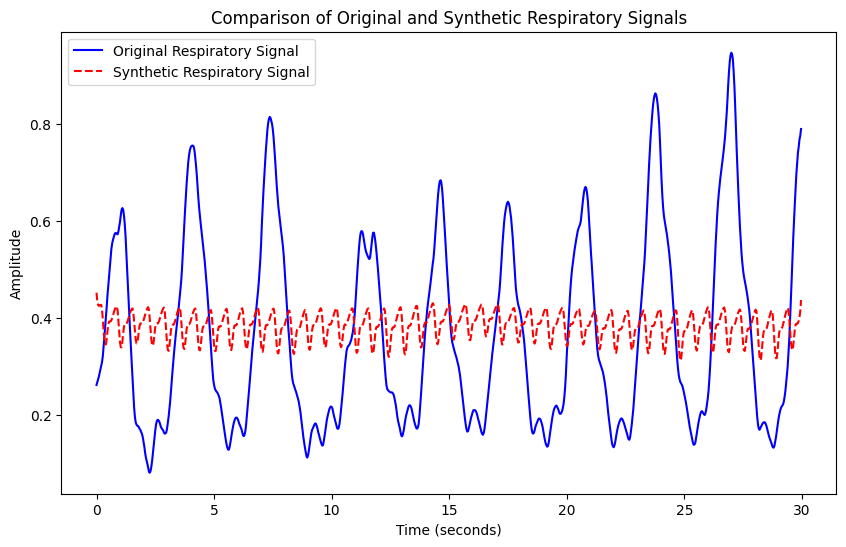

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


sample_index = 159
synthetic_signal = generator_XY.predict(test_X)[sample_index].flatten()
original_signal = test_Y[sample_index].flatten()

synthetic_signal = synthetic_signal * (np.max(original_signal) - np.min(original_signal)) + np.min(original_signal)

synthetic_signal = np.clip(synthetic_signal, 0.0, 1.0)

mae = np.mean(np.abs(synthetic_signal - original_signal))

print("Mean Absolute Error (MAE):", mae)

time_axis = np.arange(len(original_signal)) / desired_sample_rate

plt.figure(figsize=(10, 6))
plt.plot(time_axis, original_signal, label='Original Respiratory Signal', color='b')
plt.plot(time_axis, synthetic_signal, label='Synthetic Respiratory Signal', color='r', linestyle='dashed')
plt.title('Comparison of Original and Synthetic Respiratory Signals')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()




5/5 [==============================] - 0s 44ms/step
Mean Absolute Error (MAE): 0.17869373780274403


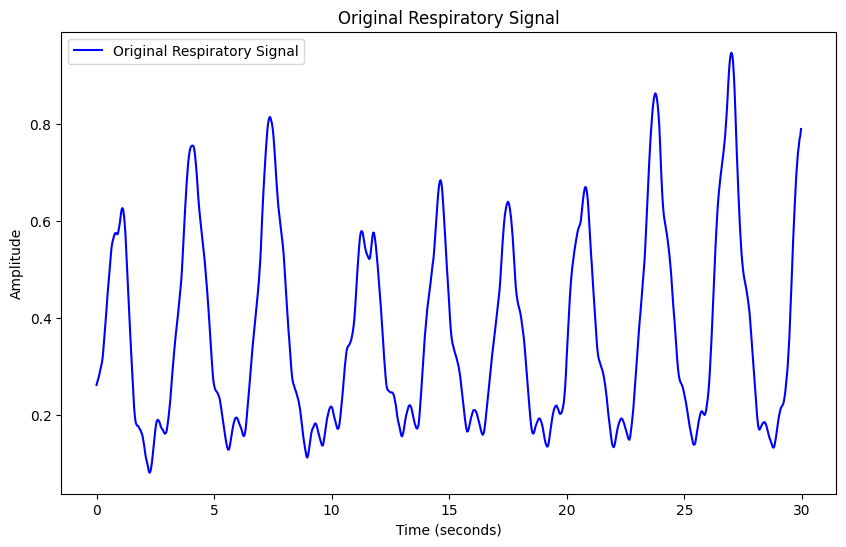

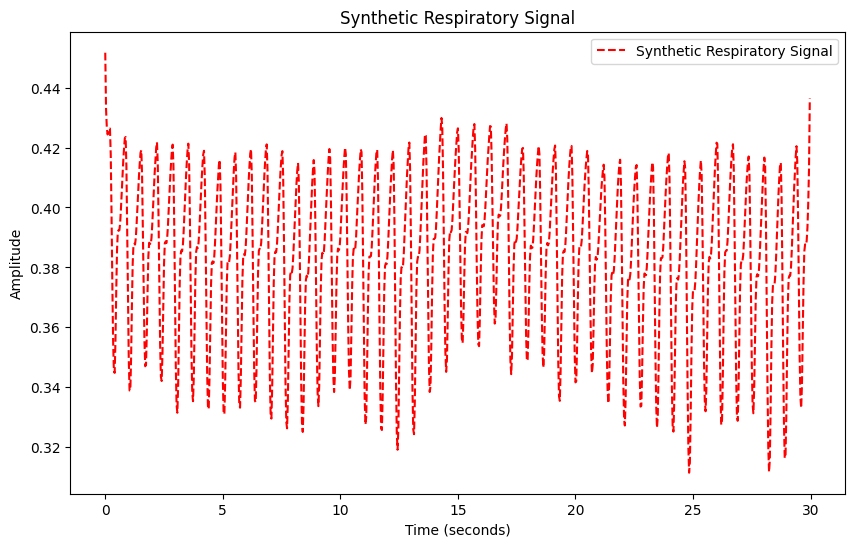

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample_index = 159


synthetic_signal = generator_XY.predict(test_X)[sample_index].flatten()
original_signal = test_Y[sample_index].flatten()

synthetic_signal = synthetic_signal * (np.max(original_signal) - np.min(original_signal)) + np.min(original_signal)

synthetic_signal = np.clip(synthetic_signal, 0.0, 1.0)

mae = np.mean(np.abs(synthetic_signal - original_signal))


print("Mean Absolute Error (MAE):", mae)


time_axis = np.arange(len(original_signal)) / desired_sample_rate

plt.figure(figsize=(10, 6))
plt.plot(time_axis, original_signal, label='Original Respiratory Signal', color='b')
plt.title('Original Respiratory Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_axis, synthetic_signal, label='Synthetic Respiratory Signal', color='r', linestyle='dashed')
plt.title('Synthetic Respiratory Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


5/5 [==============================] - 0s 44ms/step


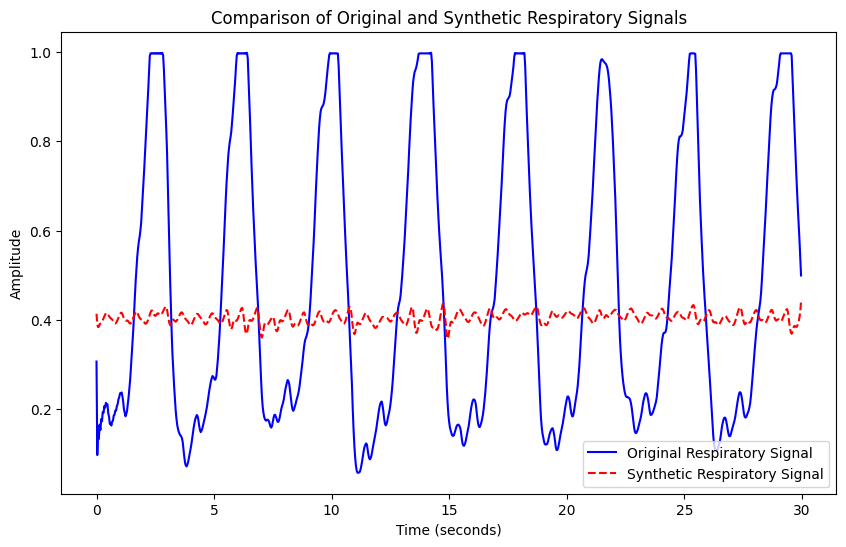

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample_index = 0


synthetic_signal = generator_XY.predict(test_X)[sample_index].flatten()
original_signal = test_Y[sample_index].flatten()


synthetic_signal = synthetic_signal * (np.max(original_signal) - np.min(original_signal)) + np.min(original_signal)

synthetic_signal = np.clip(synthetic_signal, 0.0, 1.0)


time_axis = np.arange(len(original_signal)) / desired_sample_rate

plt.figure(figsize=(10, 6))
plt.plot(time_axis, original_signal, label='Original Respiratory Signal', color='b')
plt.plot(time_axis, synthetic_signal, label='Synthetic Respiratory Signal', color='r', linestyle='dashed')
plt.title('Comparison of Original and Synthetic Respiratory Signals')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

